# Анализ продаж видеоигр: выявление закономерностей успеха

**Описание проекта**

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Перед вами данные до 2016 года.

**Цель:** выявить определяющие успешность игры закономерности.
Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


Описание данных:

`Name` — название игры

`Platform` — платформа

`Year_of_Release` — год выпуска

`Genre` — жанр игры

`NA_sales` — продажи в Северной Америке (миллионы проданных копий)

`EU_sales` — продажи в Европе (миллионы проданных копий)

`JP_sales` — продажи в Японии (миллионы проданных копий)

`Other_sales` — продажи в других странах (миллионы проданных копий)

`Critic_Score` — оценка критиков (максимум 100)

`User_Score` — оценка пользователей (максимум 10)

`Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np

%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('figure', figsize=(15, 6))


# Подготовка данных

In [43]:
# загружаем датасет
df = pd.read_csv('/content/drive/MyDrive/Data_analysis/games.csv')

In [44]:
# просмотр датасета
df.head()

Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN

Названия столбцов написаны с большой буквы, приведем к нижнему регистру


In [45]:
# Приводим названия столбцов к нижнему регистру
df.columns = df.columns.str.lower()

In [46]:
# посмотрим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


- Столбцы в нижнем регистре.
- Колонка `year_of_release` в формате float, можно перевести в формат даты, но так как нас интересует год, то лучше перевести в формат int.
- Колонка `user_score` в формате object. Надо перевести в числовой формат.
- Пропуска есть почти в каждой колонке. В тех колонках, где пропусков менее 5% удалим их. В колонках `critic_score`, `user_score` и `rating` удалять не будем, так как их слишком много.

In [47]:
# проверим количество дубликатов
df.duplicated().sum()

np.int64(0)

Явных дубликатов нет

In [48]:
# выведем долю пропущенных значений по столбцам
df.isna().mean()

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.400897
rating             0.404786
dtype: float64

Можно удалить дубликаты в столбцах `name`, `year_of_release` и `genre`, так как в них меньше 5% пропущенных значений. В последних трех столбцах удалять не будем, так как потеряем много данных.

Причины появления пропусков могут быть разными:
- Неверная кодировка, которая не былоа распознана при переносе данных.
- Человеческая ошибка при наборе данных.
- Отсутствие таких понятий как оценка критиков, оценка пользователей и рейтинг для старых игр.
- Новая игра еще не получила оценок.

In [49]:
# удаляем пропущенные значения в столбцах name, year_of_release и genre
df = df.dropna(subset=['name', 'year_of_release', 'genre'])

In [50]:
# Преобразуем столбец `year_of_release` в тип int
df['year_of_release'] = df['year_of_release'].astype(int)

/tmp/ipython-input-50-1125387639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_of_release'] = df['year_of_release'].astype(int)


In [51]:
# проверим количество пропущенных значений снова
df.isna().mean()

name               0.000000
platform           0.000000
year_of_release    0.000000
genre              0.000000
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.514534
user_score         0.401666
rating             0.405984
dtype: float64

Строчки с пропущенными значениями удалились.

In [52]:
# посмотрим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


Надо изменить тип колонки с оценками пользователей.
Проверим, что послужило причиной того, что эта колонка имеет формат object

In [53]:
# Посчитаем втречаемость значений в колонке user_score
df['user_score'].value_counts(dropna=False)

user_score
NaN    6605
tbd    2376
7.8     322
8       285
8.2     276
       ... 
1.3       2
1         2
0.9       2
0         1
9.7       1
Name: count, Length: 97, dtype: int64

Больше всего пропусков - 6605. На втором месте строка `tbd`. Согласно интернету это аббривиатура сокращения `to be determined`, то есть "предстоит определить" или "подлежит уточнению". Фактически это означает, что данные пропущены.

In [54]:
df.query('user_score == "tbd"')

name platform  year_of_release       genre  \
119                     Zumba Fitness      Wii             2010      Sports   
301    Namco Museum: 50th Anniversary      PS2             2005        Misc   
520                   Zumba Fitness 2      Wii             2011      Sports   
645                      uDraw Studio      Wii             2010        Misc   
718                   Just Dance Kids      Wii             2010        Misc   
...                               ...      ...              ...         ...   
16695                 Planet Monsters      GBA             2001      Action   
16697                Bust-A-Move 3000       GC             2003      Puzzle   
16698                Mega Brain Boost       DS             2008      Puzzle   
16704                        Plushees       DS             2008  Simulation   
16706   Men in Black II: Alien Escape       GC             2003     Shooter   

       na_sales  eu_sales  jp_sales  other_sales  critic_score user_score  \
119        3.45      2.59       0.0         0.66           NaN        tbd   
301        2.08      1.35       0.0         0.54          61.0        tbd   
520        1.51      1.03       0.0         0.27           NaN        tbd   
645        1.65      0.57       0.0         0.20          71.0        tbd   
718        1.52      0.54       0.0         0.18           NaN        tbd   
...         ...       ...       ...          ...           ...        ...   
16695      0.01      0.00       0.0         0.00          67.0        tbd   
16697      0.01      0.00       0.0         0.00          53.0        tbd   
16698      0.01      0.00       0.0         0.00          48.0        tbd   
16704      0.01      0.00       0.0         0.00           NaN        tbd   
16706      0.01      0.00       0.0         0.00           NaN        tbd   

      rating  
119        E  
301     E10+  
520        T  
645        E  
718        E  
...      ...  
16695      E  
16697      E  
16698      E  
16704      E  
16706      T  

[2376 rows x 11 columns]

Появляется это значение среди игра разных платформ и разного года выпуска. Возможно издатель не предоставил возможности проставить пользователям оценку на игру, либо есть опреределенный порог количества оценок, после которого оценки будут видны, но этот порог не был достигнут. Считаю, что данные значения, как и пропуски мы заменим на 0, что часто означет, что рейтинга нет.

In [55]:
# заменим значение tbd на 0 в столбце user_score
df['user_score'] = df['user_score'].replace('tbd', 0)

In [56]:
# заполним пропуски в столбцах critic_score и user_score значением -1
df[['critic_score', 'user_score']] = df[['critic_score', 'user_score']].fillna(0)
df.isna().mean()

name               0.000000
platform           0.000000
year_of_release    0.000000
genre              0.000000
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.000000
user_score         0.000000
rating             0.405984
dtype: float64

In [57]:
# Посчитаем значения в колонке рейтинг
df['rating'].value_counts(dropna=False)

rating
NaN     6676
E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: count, dtype: int64

6676 пропущенных значений. Есть немного рейтингов EC - «Early childhood». Сейчас не используется и соответствует рейтингу E - «Everyone». Изменим 'nb значения на E. K-A - "Kids to Adults" тоже не используется и соответствует рейтингу E. «AO» («Adults Only 18+») - можно изменить на близкое по смыслу «M» («Mature») — «Для взрослых». Тем более, что такая игра всего одна. «RP» («Rating Pending») — «Рейтинг ожидается». То есть, фактически рейтинга нет. Думаю, что NaN можно заменить на RP и в будущем отфильтровать при необходимости.

In [58]:
# Заменяем значения EC на E
df['rating'] = df['rating'].str.replace('EC', 'E')
# Заменяем значения K-A на E
df['rating'] = df['rating'].str.replace('K-A', 'E')
# Заменяем значения A на M
df['rating'] = df['rating'].str.replace('AO', 'M')
# Заменяем значения NaN на RP
df['rating'] = df['rating'].fillna('RP')
# Посчитаем значения в колонке рейтинг
df['rating'].value_counts(dropna=False)

rating
RP      6677
E       3932
T       2905
M       1537
E10+    1393
Name: count, dtype: int64

In [59]:
# проверим на пропуски
df.isna().mean()

name               0.0
platform           0.0
year_of_release    0.0
genre              0.0
na_sales           0.0
eu_sales           0.0
jp_sales           0.0
other_sales        0.0
critic_score       0.0
user_score         0.0
rating             0.0
dtype: float64

Пропусков больше нет.

In [60]:
# выведем общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  object 
 10  rating           16444 non-null  object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


In [61]:
# Изменим тип ячейки user_score на float
df['user_score'] = df['user_score'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Еще необходимо посчитать суммарные продажи во всех регионах и записать их в отдельный столбец.

In [62]:
# Подсчет суммарныех продаж во всех регионах
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii             2006        Sports     41.36   
1         Super Mario Bros.      NES             1985      Platform     29.08   
2            Mario Kart Wii      Wii             2008        Racing     15.68   
3         Wii Sports Resort      Wii             2009        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB             1996  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score  user_score rating  \
0     28.96      3.77         8.45          76.0         8.0      E   
1      3.58      6.81         0.77           0.0         0.0     RP   
2     12.76      3.79         3.29          82.0         8.3      E   
3     10.93      3.28         2.95          80.0         8.0      E   
4      8.89     10.22         1.00           0.0         0.0     RP   

   total_sales  
0        82.54  
1        40.24  
2        35.52  
3        32.77  
4        31.38

В итоге:
- Привели названия столбцов к нижнему регистру.
- Типы колонок изменили на нужные.
- Удалили не больше 5% пропусков.
- В колонках `critic_score` и `user_score `, пропуски заменили на 0.
- В колонке `rating ` на RP.
- Дубликатов не обнаружено.

# Исследовательский анализ данных (EDA)

### Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

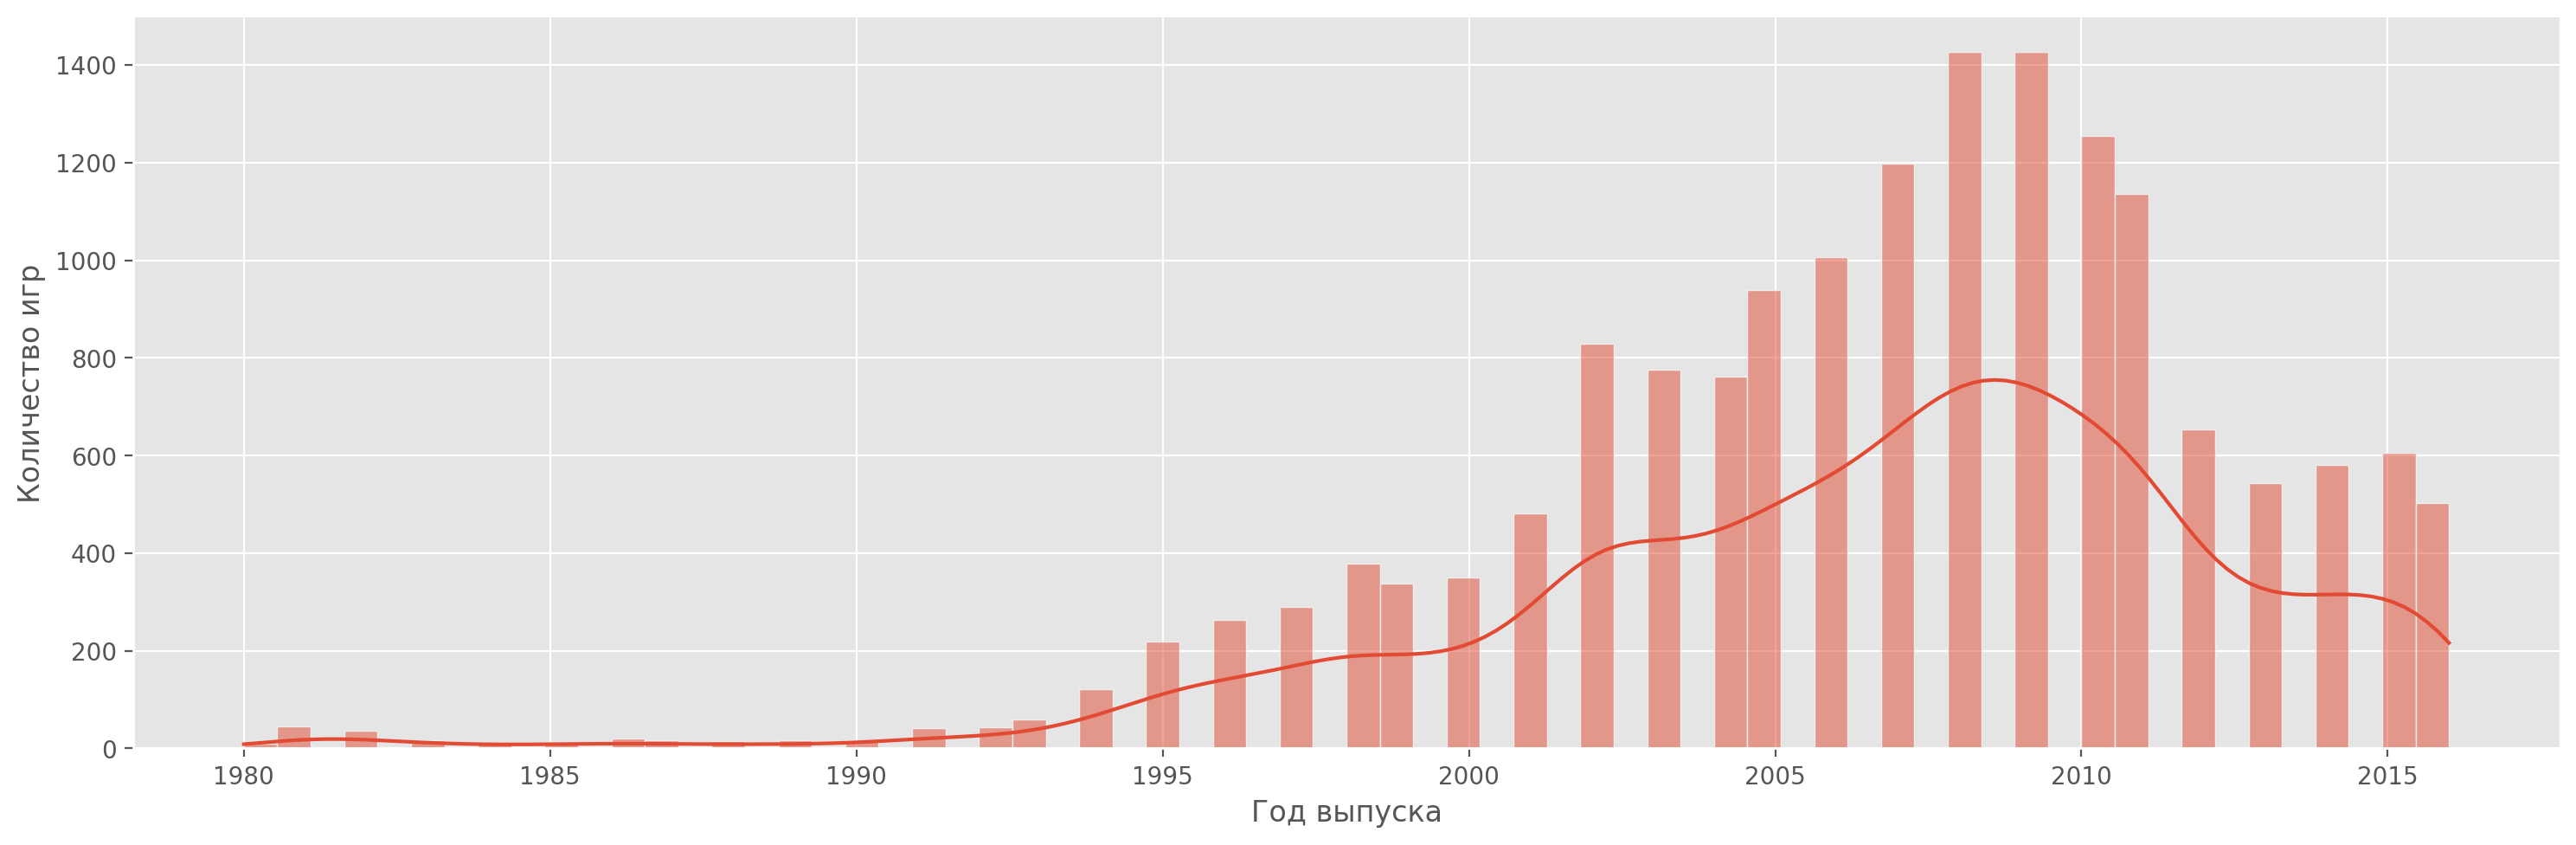

In [63]:
# построим график зависимости количества игр от года выпуска
sns.displot(data = df,
            x='year_of_release',
            kde=True,
            aspect=3)
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр')
plt.show()

До 1991 года игр выпускалось очень мало. Соответственно, можно рассматривать данные только с 1991 года.

In [64]:
# оставим данные только с 1991 года
df_since_1991 = df.query('year_of_release >= 1991')
# посмотрим сколько данных мы потеряли
round((df.shape[0] - df_since_1991.shape[0])/df.shape[0], 3)

0.013

Отфильтровалось чуть больше 1 процента данных. Не так и много.


### Изменение продаж по платформам

In [65]:
# изменение продаж в зависимости от платформы. платформы с наибольшими суммарными продажами и постройте распределение по годам
platform_sales = df_since_1991.groupby('platform', as_index=False).agg({'total_sales': 'sum'})
top_10_platforms = platform_sales.sort_values(by='total_sales', ascending=False).head(10)

top_10_platforms

platform  total_sales
15      PS2      1233.56
27     X360       961.24
16      PS3       931.34
25      Wii       891.18
3        DS       802.76
14       PS       727.58
17      PS4       314.14
5       GBA       312.88
18      PSP       289.53
1       3DS       257.81

In [66]:
# вычленим названия платформ из топ-10
top_10_platforms_names = top_10_platforms['platform'].tolist()
top_10_platforms_names

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS']

In [67]:
# Оставим в данных только платформы из топ-10
df_since_1991_top10 = df_since_1991[df_since_1991['platform'].isin(top_10_platforms_names)]

In [68]:
# Сгруппируем по году выпуска и платформе и посчитаем суммарные продажи
top10_platform_sales = df_since_1991_top10.groupby(['year_of_release', 'platform'], as_index=False).agg({'total_sales': 'sum'})
# Заменим названия колонок на удобочитаемые
top10_platform_sales = top10_platform_sales.rename(columns={'year_of_release': 'Год продаж игр',
                                                            'platform': 'Платформа',
                                                            'total_sales': 'Выручка'})

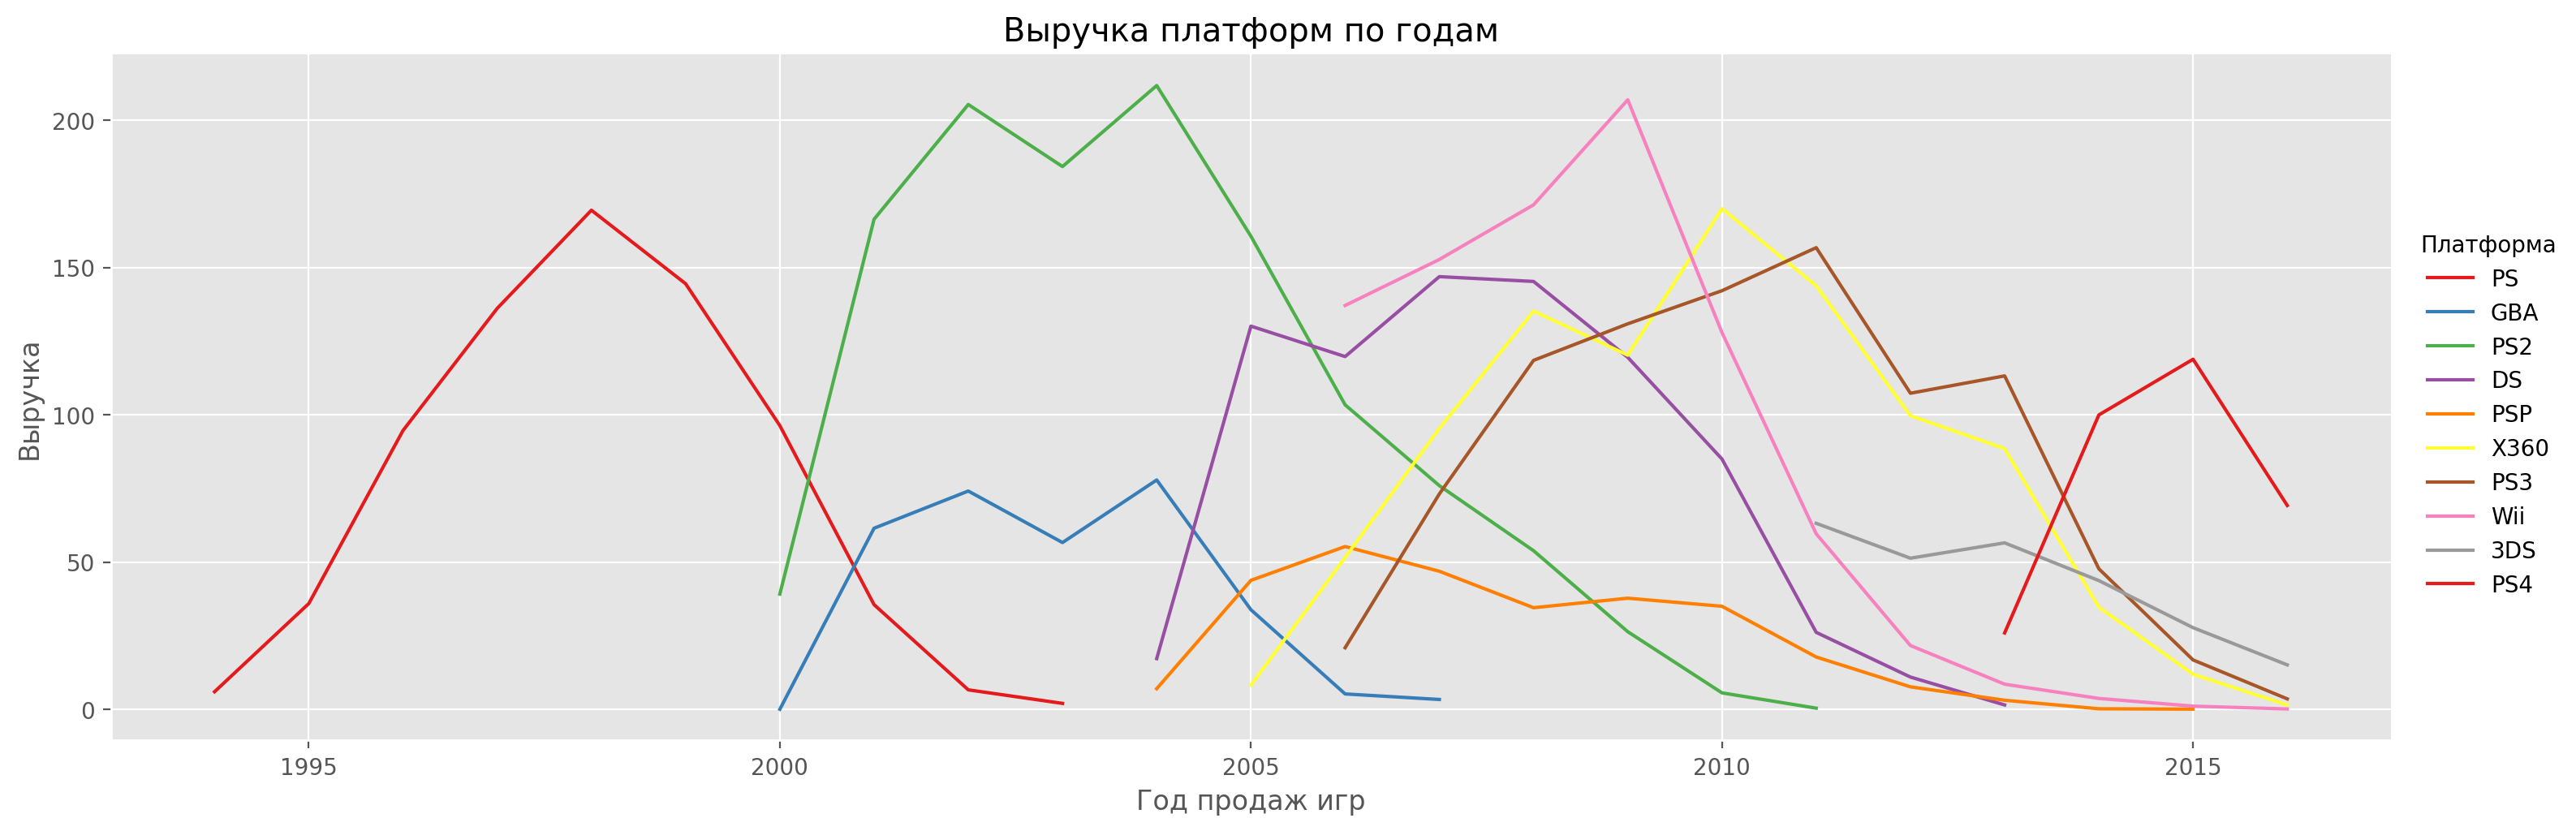

In [69]:
# Построим график зависимости продаж по годам в зависимости от платформы
sns.relplot(data=top10_platform_sales,
            x='Год продаж игр',
            y='Выручка',
            hue='Платформа',
            kind='line',
            aspect = 3,
            palette='Set1'
            )
plt.title('Выручка платформ по годам')
plt.show()

По графику видно, что у платформ есть пик продаж и затем следует спад. Можно вычислить среднее время "жизни" платформы.

In [70]:
# вычисляем минимальный и максимальный год выпуска
year_of_release_max = df_since_1991_top10.groupby('platform', as_index=False).agg({'year_of_release': 'max'})
year_of_release_min = df_since_1991_top10.groupby('platform', as_index=False).agg({'year_of_release': 'min'})

In [71]:
# объединим данные
platforms_lifespan = year_of_release_max.merge(year_of_release_min, on='platform')
# изменим назания колонок года выпуска
platforms_lifespan = platforms_lifespan.rename(columns={'year_of_release_x': 'year_of_release_max',
                                                            'year_of_release_y': 'year_of_release_min'})
# посчитаем разницу
platforms_lifespan['Lifespan'] = platforms_lifespan['year_of_release_max'] - platforms_lifespan['year_of_release_min']
platforms_lifespan = platforms_lifespan.sort_values(by='Lifespan', ascending=False)

In [72]:
# функция построения графика типа bar
def bar_plot(data, x, y, xlable=None, ylable=None, title=None):
    ax=sns.barplot(data=data,
                x=x,
                y=y,
                )
    ax.bar_label(ax.containers[0])
    plt.xlabel(xlable)
    plt.ylabel(ylable)
    plt.title(title)
    plt.show()

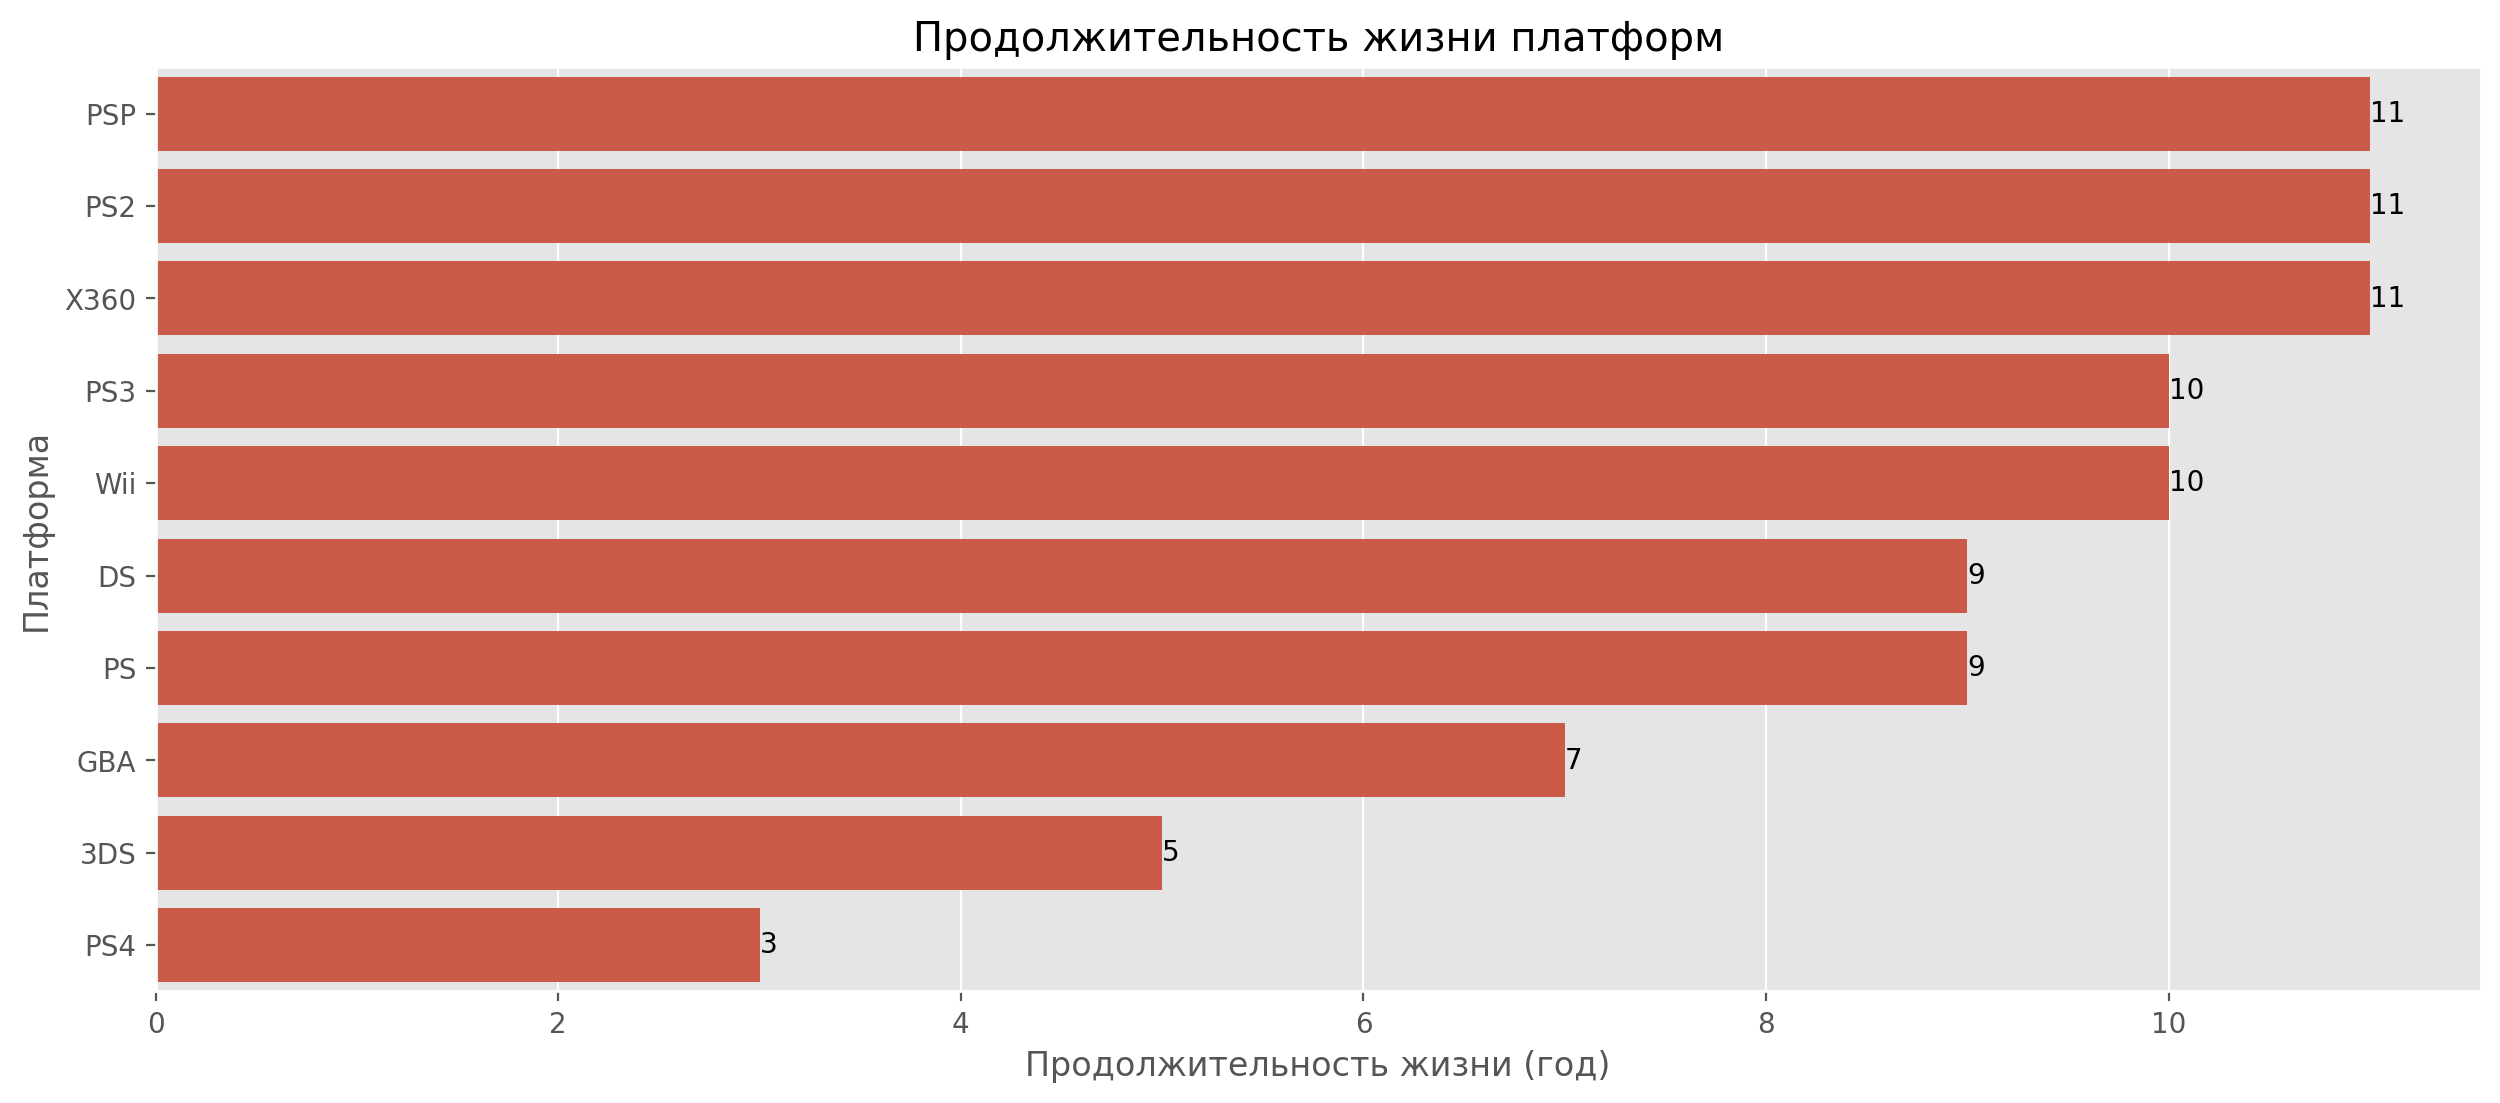

In [73]:
# Построим график зависимости продаж по годам в зависимости от платформы
bar_plot(platforms_lifespan, 'Lifespan', 'platform', 'Продолжительность жизни (год)', 'Платформа', 'Продолжительность жизни платформ')

In [74]:
# вычислим среднее и медиану по продолжительности жизни платформ
print(f'Средняя продолжительность "жизни" платформы \
{platforms_lifespan["Lifespan"].mean()} лет \
и медиана {platforms_lifespan["Lifespan"].median()} лет')

Средняя продолжительность "жизни" платформы 8.6 лет и медиана 9.5 лет


Продолжительность "жизни" платформ из топ 10 составляет примерно 9 лет.
Сравним с оставшимися платформами.

In [75]:
# Оставим в данных только платформы не из топ-10
df_since_1991_loosers = df_since_1991[~df_since_1991['platform'].isin(top_10_platforms_names)]
# Сгруппируем по году выпуска и платформе и посчитаем суммарные продажи
loosers_platform_sales = df_since_1991_loosers.groupby(['year_of_release', 'platform'], as_index=False).agg({'total_sales': 'sum'})

In [76]:
# вычисляем минимальный и максимальный год выпуска
year_of_release_max = loosers_platform_sales.groupby('platform', as_index=False).agg({'year_of_release': 'max'})
year_of_release_min = loosers_platform_sales.groupby('platform', as_index=False).agg({'year_of_release': 'min'})
# объединим данные
platforms_lifespan = year_of_release_max.merge(year_of_release_min, on='platform')
# изменим назания колонок года выпуска
platforms_lifespan = platforms_lifespan.rename(columns={'year_of_release_x': 'year_of_release_max',
                                                            'year_of_release_y': 'year_of_release_min'})
# посчитаем разницу
platforms_lifespan['Lifespan'] = platforms_lifespan['year_of_release_max'] - platforms_lifespan['year_of_release_min']
# вычислим среднее и медиану по продолжительности жизни платформ
print(f'Средняя продолжительность "жизни" платформы \
{platforms_lifespan["Lifespan"].mean()} лет \
и медиана {platforms_lifespan["Lifespan"].median()} лет')

Средняя продолжительность "жизни" платформы 5.1 лет и медиана 3.5 лет


In [77]:
# Выведем платформы - лузеры
platforms_lifespan.sort_values(by='Lifespan', ascending=False)

platform  year_of_release_max  year_of_release_min  Lifespan
9        PC                 2016                 1992        24
1        DC                 2008                 1998        10
2        GB                 2001                 1991        10
14     SNES                 1999                 1991         8
18       XB                 2008                 2000         8
3        GC                 2007                 2001         6
6       N64                 2002                 1996         6
11      PSV                 2016                 2011         5
12      SAT                 1999                 1994         5
17     WiiU                 2016                 2012         4
19     XOne                 2016                 2013         3
4       GEN                 1994                 1991         3
7       NES                 1994                 1991         3
8        NG                 1996                 1993         3
16       WS                 2001                 1999         2
0       3DO                 1995                 1994         1
13      SCD                 1994                 1993         1
5        GG                 1992                 1992         0
10     PCFX                 1996                 1996         0
15     TG16                 1995                 1995         0

Среди платформ, у которых продажи ниже средняя продолжительность "жизни" тоже ниже, что логично: меньше денег - меньше возможности поддерживать существование.
Отличаются только три платформы - PC, GB, DC - у них продолжительность жизни такая же, как у топов. Что говорит о том, что можно было взять не топ 10, а топ 13. Тогда время существования аутсайдеров была бы еще ниже.
Наибольшее время существование у PC, что объясняется простотой апгрейда и количеством - персональных компьютеров сильно больше чем отдельных платформ. Не самые высокие показатели выручки объясняются относительно низкой стоимостью игр для РС.

### Выбор актуального периода

Исходя из данных выше, примем за актуальный период - 10 лет от 2017 года. Это примерное время жизни топа платформ из наших данных. Соответственно, все данные, что до 2007 года нас не будут интересовать.

In [78]:
# выбираем данные с 2007 года включительно
df_since_2013 = df.query('year_of_release >= 2013').copy()

In [79]:
# Какие платформы лидируют по продажам
platform_sales_since_2013 = (df_since_2013.groupby('platform', as_index=False)
              .agg({'total_sales': 'sum'})
              .sort_values(by='total_sales', ascending=False))

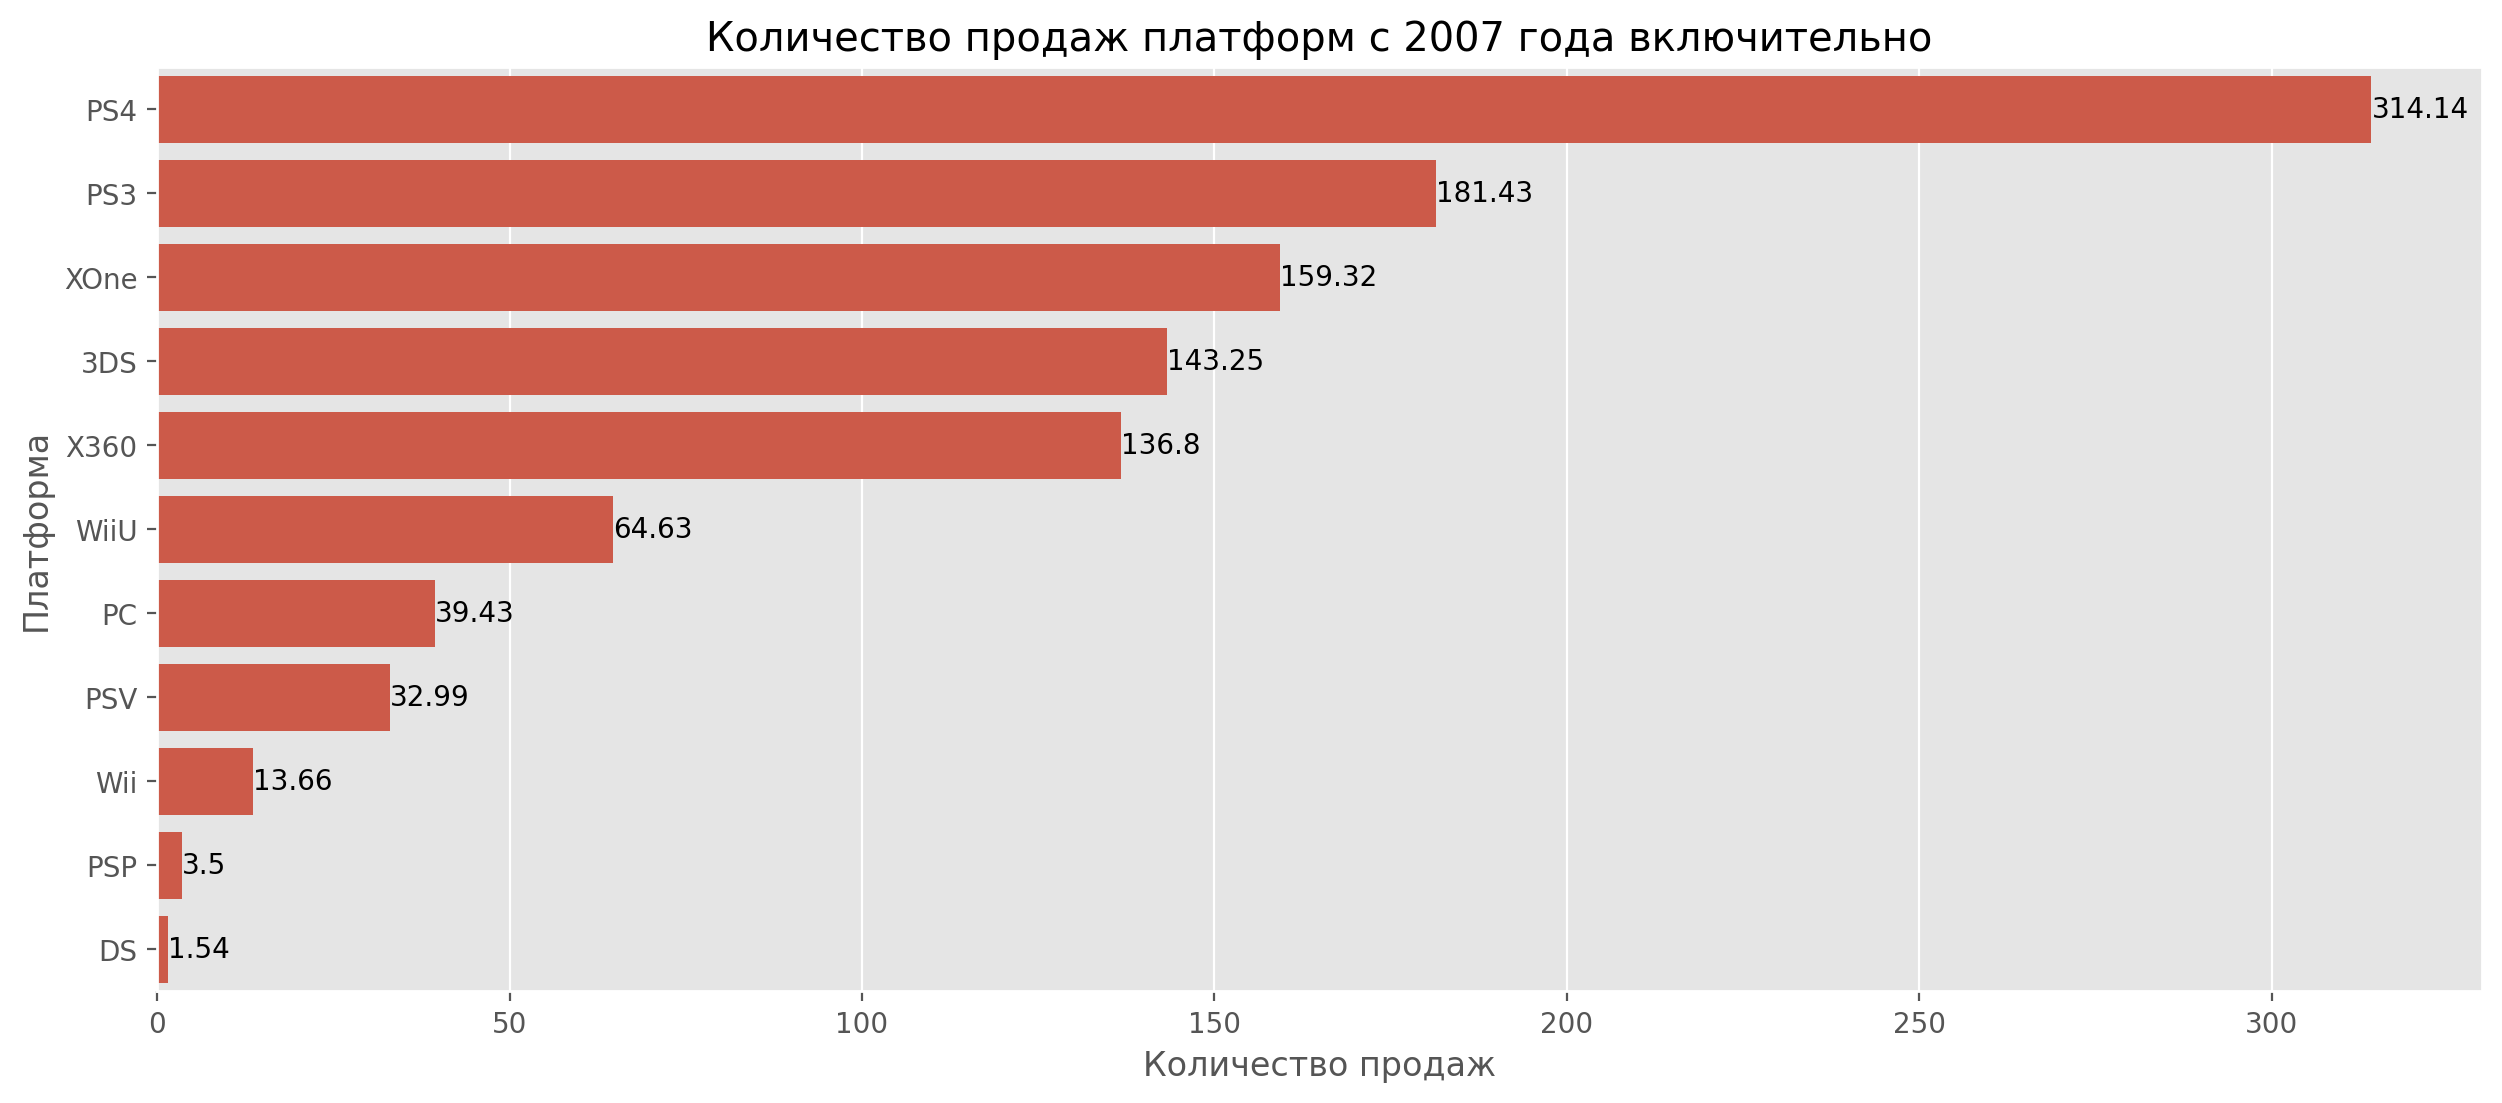

In [80]:
# Построим график выручки платформ с 2007 года включительно
bar_plot(platform_sales_since_2013, 'total_sales', 'platform', 'Количество продаж', 'Платформа', 'Количество продаж платформ с 2007 года включительно')

С 2013 года наибольшее количество проданных копий игр c большим отрывом наблюдается на платформах PS4 (314 млн. проданных копий игр). Далее следует PS3. Наименьшее количество у платформы DS (1.54 млн. проданных копий игр).
Посмотрим на количество игр.

In [81]:
# количество проданных игр по платформам
games_count_per_platform = (df_since_2013.groupby('platform', as_index=False)
              .agg({'name': 'count'})
              .sort_values(by='name', ascending=False))

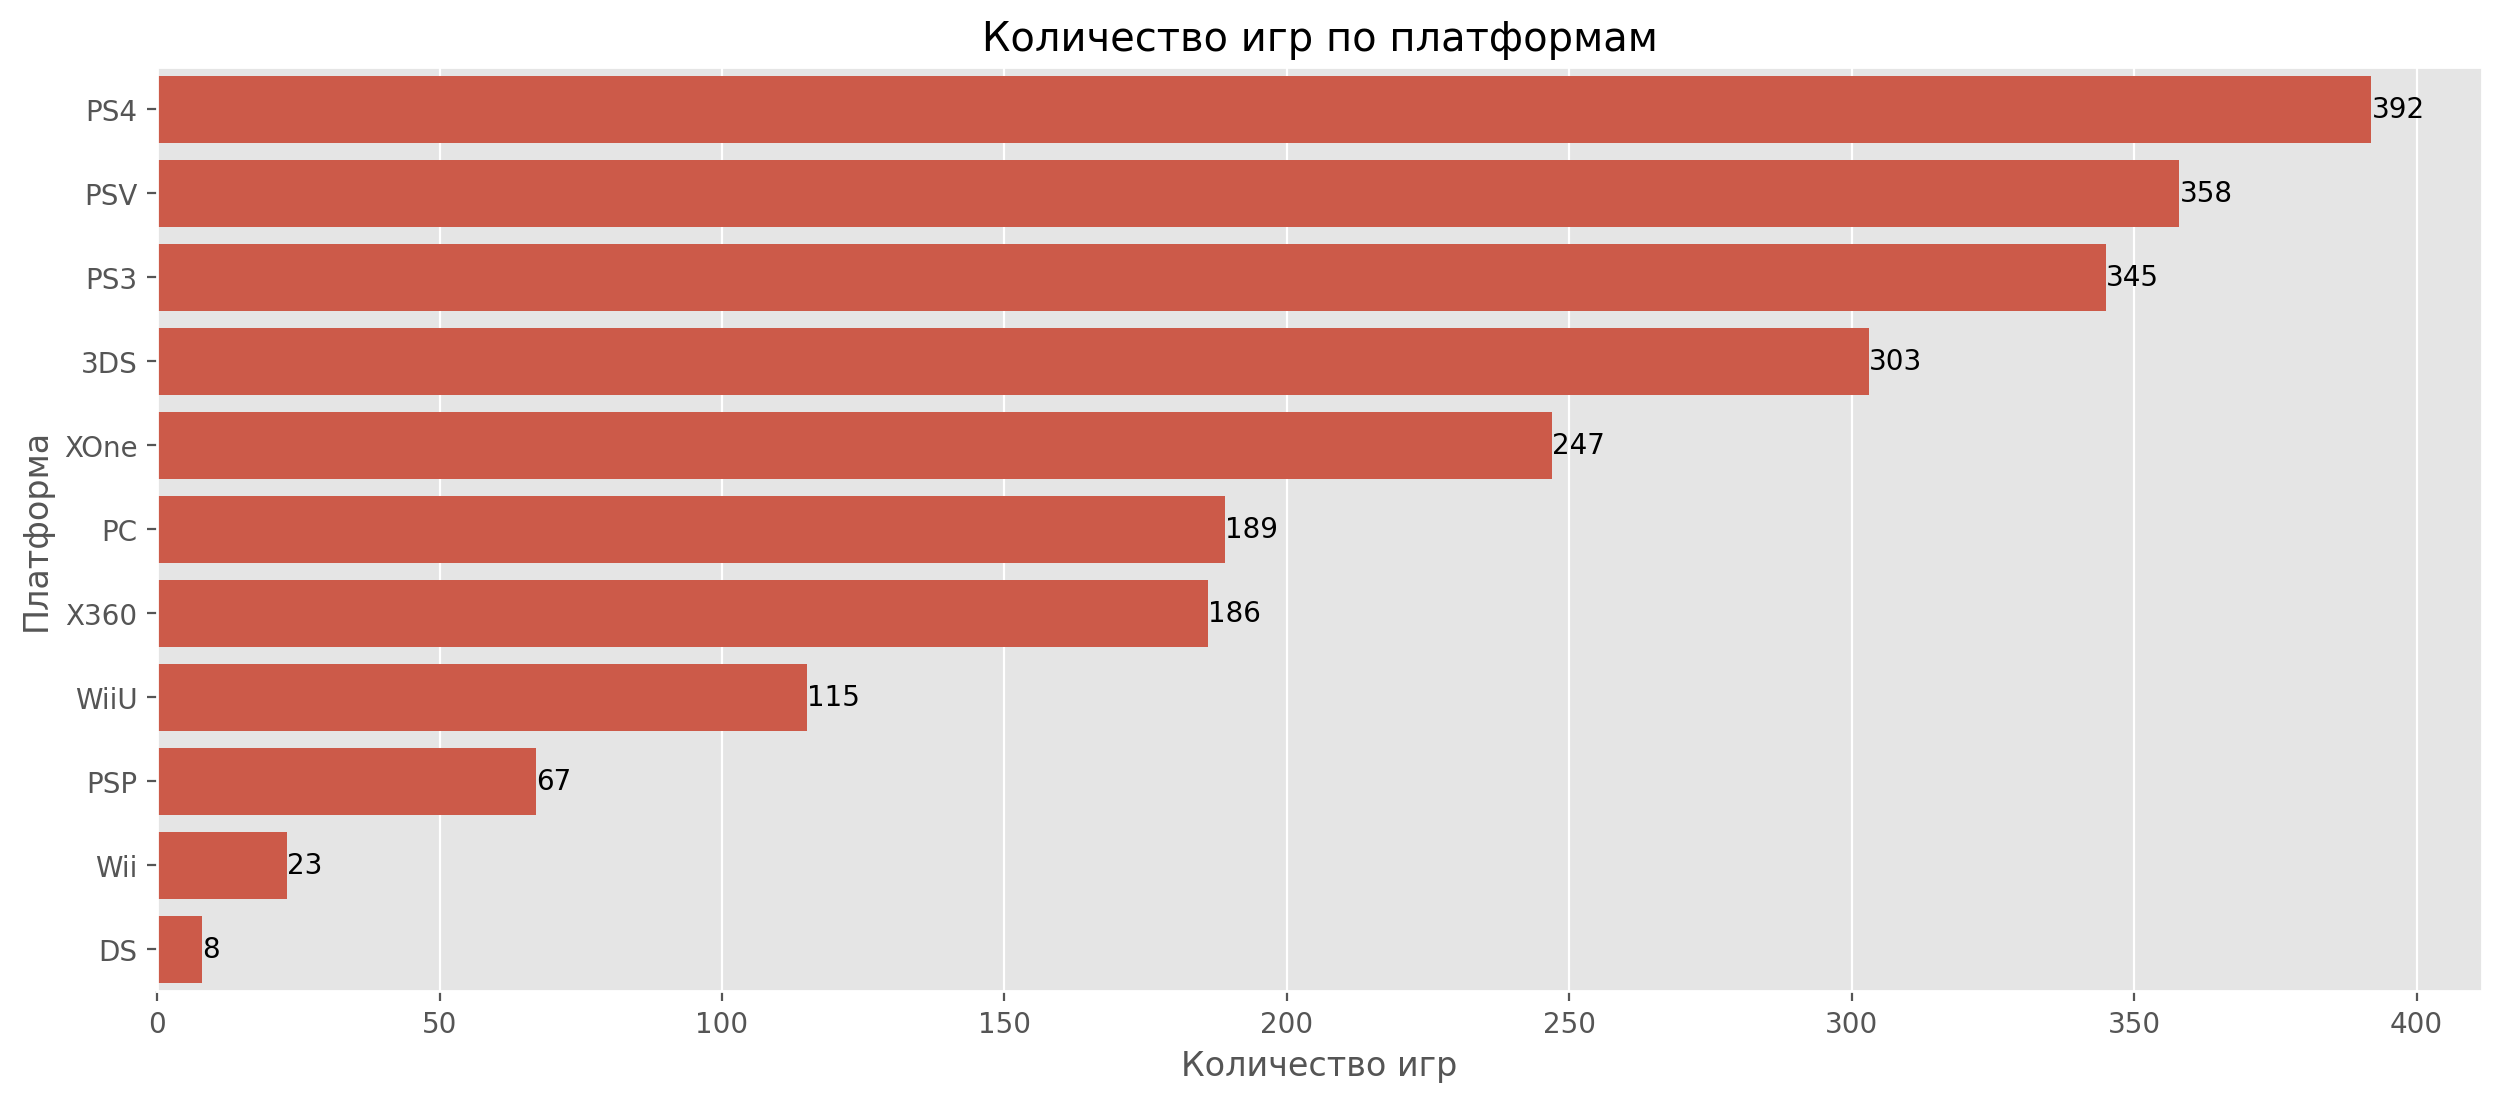

In [82]:
bar_plot(games_count_per_platform, x='name', y='platform', xlable='Количество игр', ylable='Платформа', title='Количество игр по платформам')

Количество игр на платформе PS4 (392 игры) больше, чем у остальных игр. На втором месте - PSV (358 игр), и на третьем - PS3 (345 игр). Среди аутсайдеров - Wii (23 игры) и DS (8 игр).

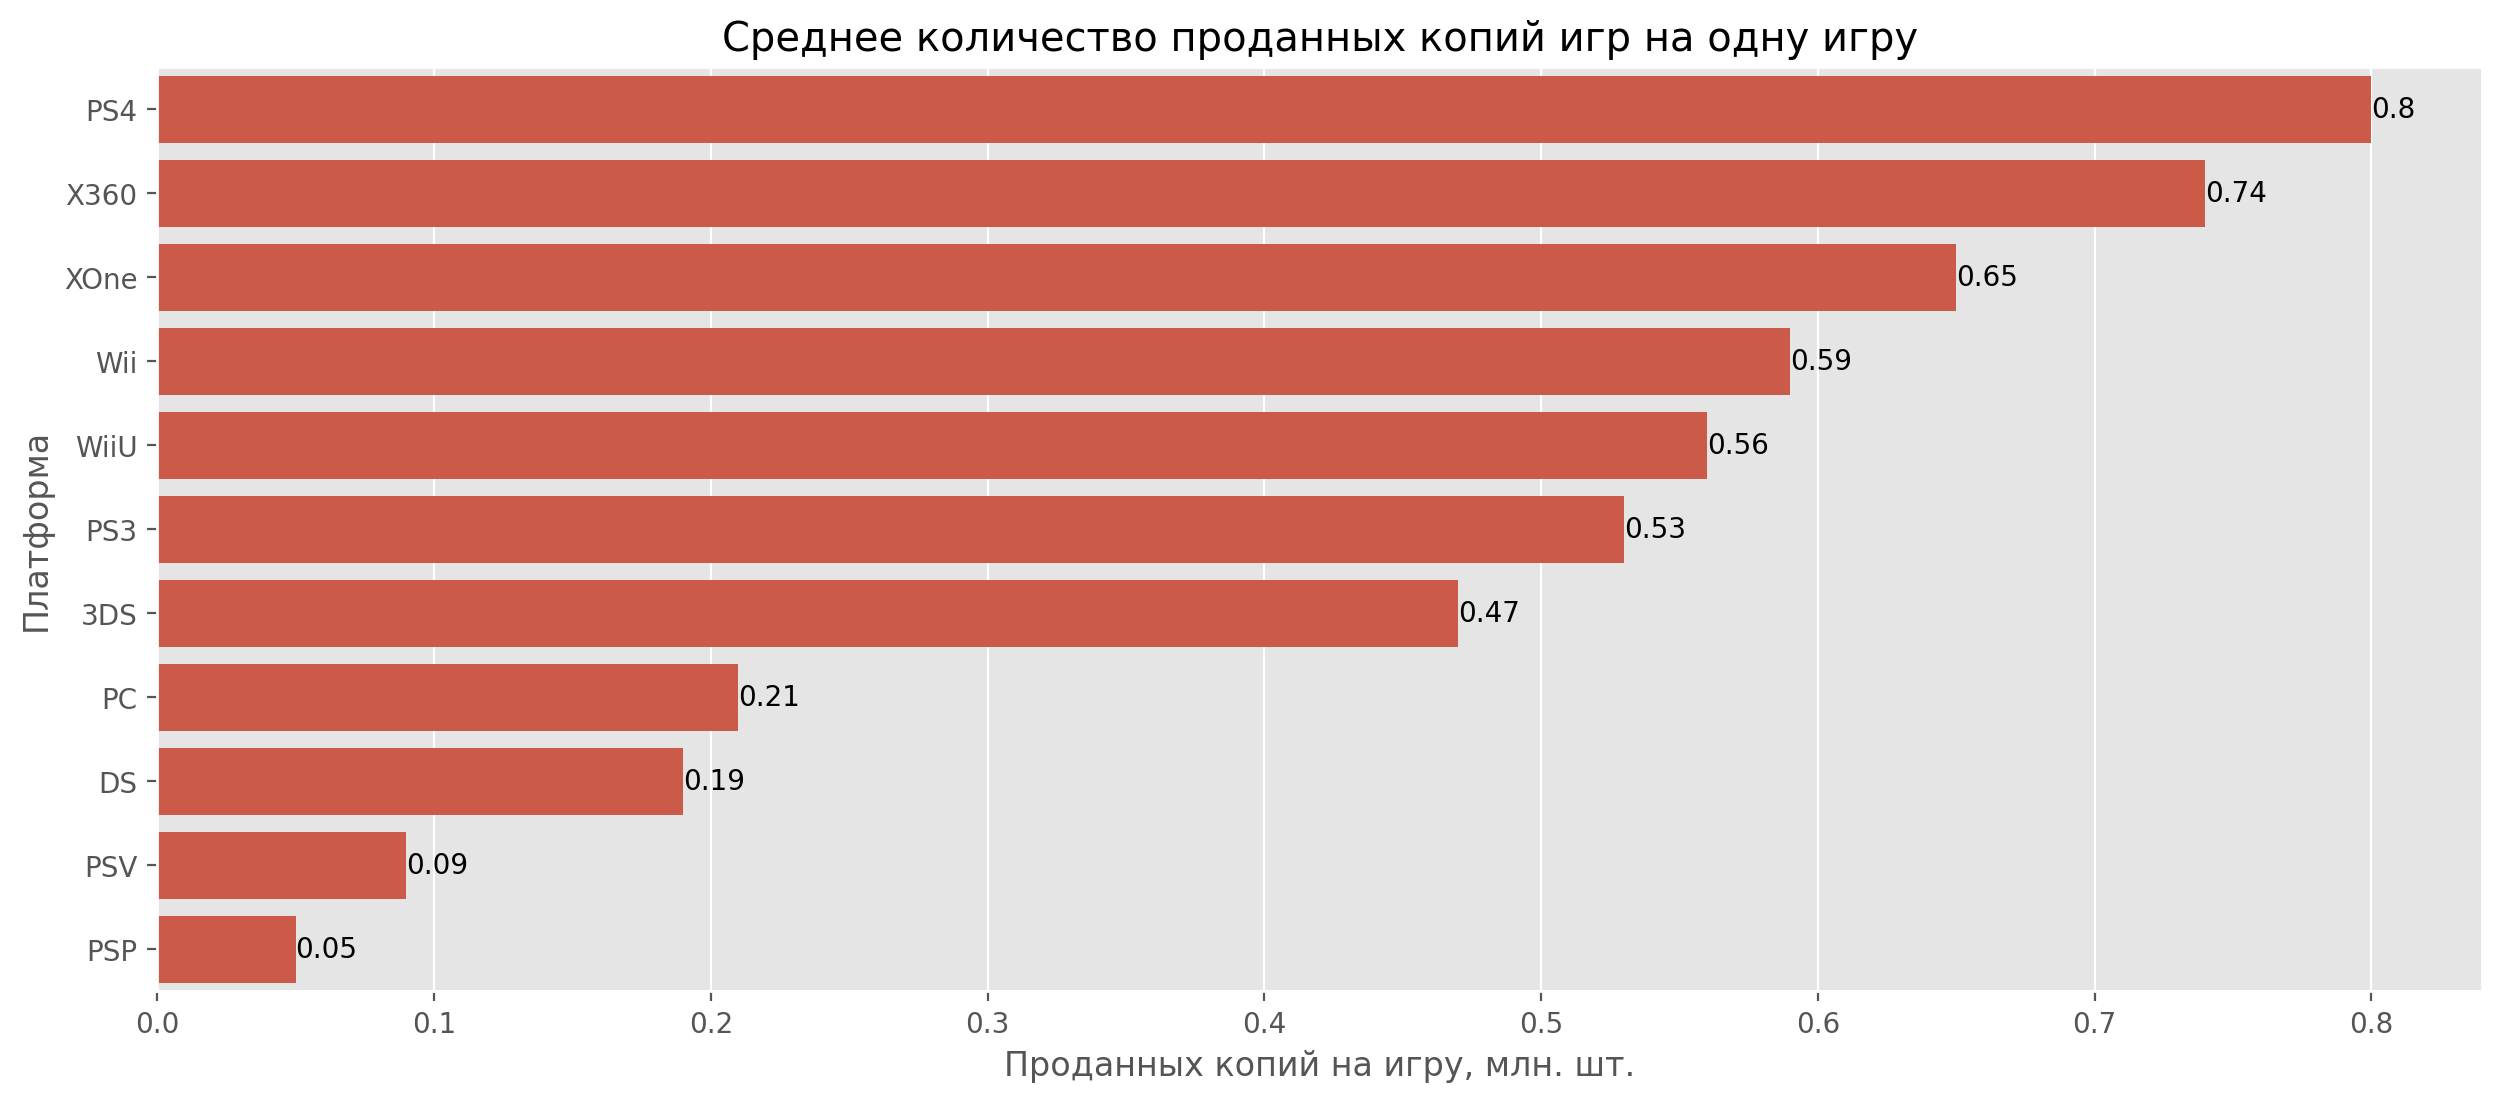

In [83]:
# посчитаем количество проданных копий игр на количество выпущенных игр на платформе
games_platform = games_count_per_platform.merge(platform_sales_since_2013, on='platform')
games_platform['mean_game_sales'] = round(games_platform['total_sales']/ games_platform['name'],2)
games_platform = games_platform.sort_values(by='mean_game_sales', ascending=False)
bar_plot(games_platform, 'mean_game_sales', 'platform', 'Проданных копий на игру, млн. шт.', 'Платформа', 'Среднее количество проданных копий игр на одну игру')

По этому графику видно, что лучше игры продаются у платформ Sony (PS4 - 0.8 млн. копий на игру) и Microsoft(XOne, X360 - 0.74 и 0.65 млн. копий на игру). Хуже всех - у PSP (0.05 млн. копий на игру).

In [84]:
def rel_plot(data, x, y, hue=None, xlable=None, ylable=None, title=None, palette='Set1', aspect=3, kind='line', col=None):
    sns.relplot(data=data,
                x=x,
                y=y,
                hue=hue,
                kind=kind,
                aspect=aspect,
                palette=palette,
                col=col
                )
    plt.xlabel(xlable)
    plt.ylabel(ylable)
    plt.title(title)
    plt.show()

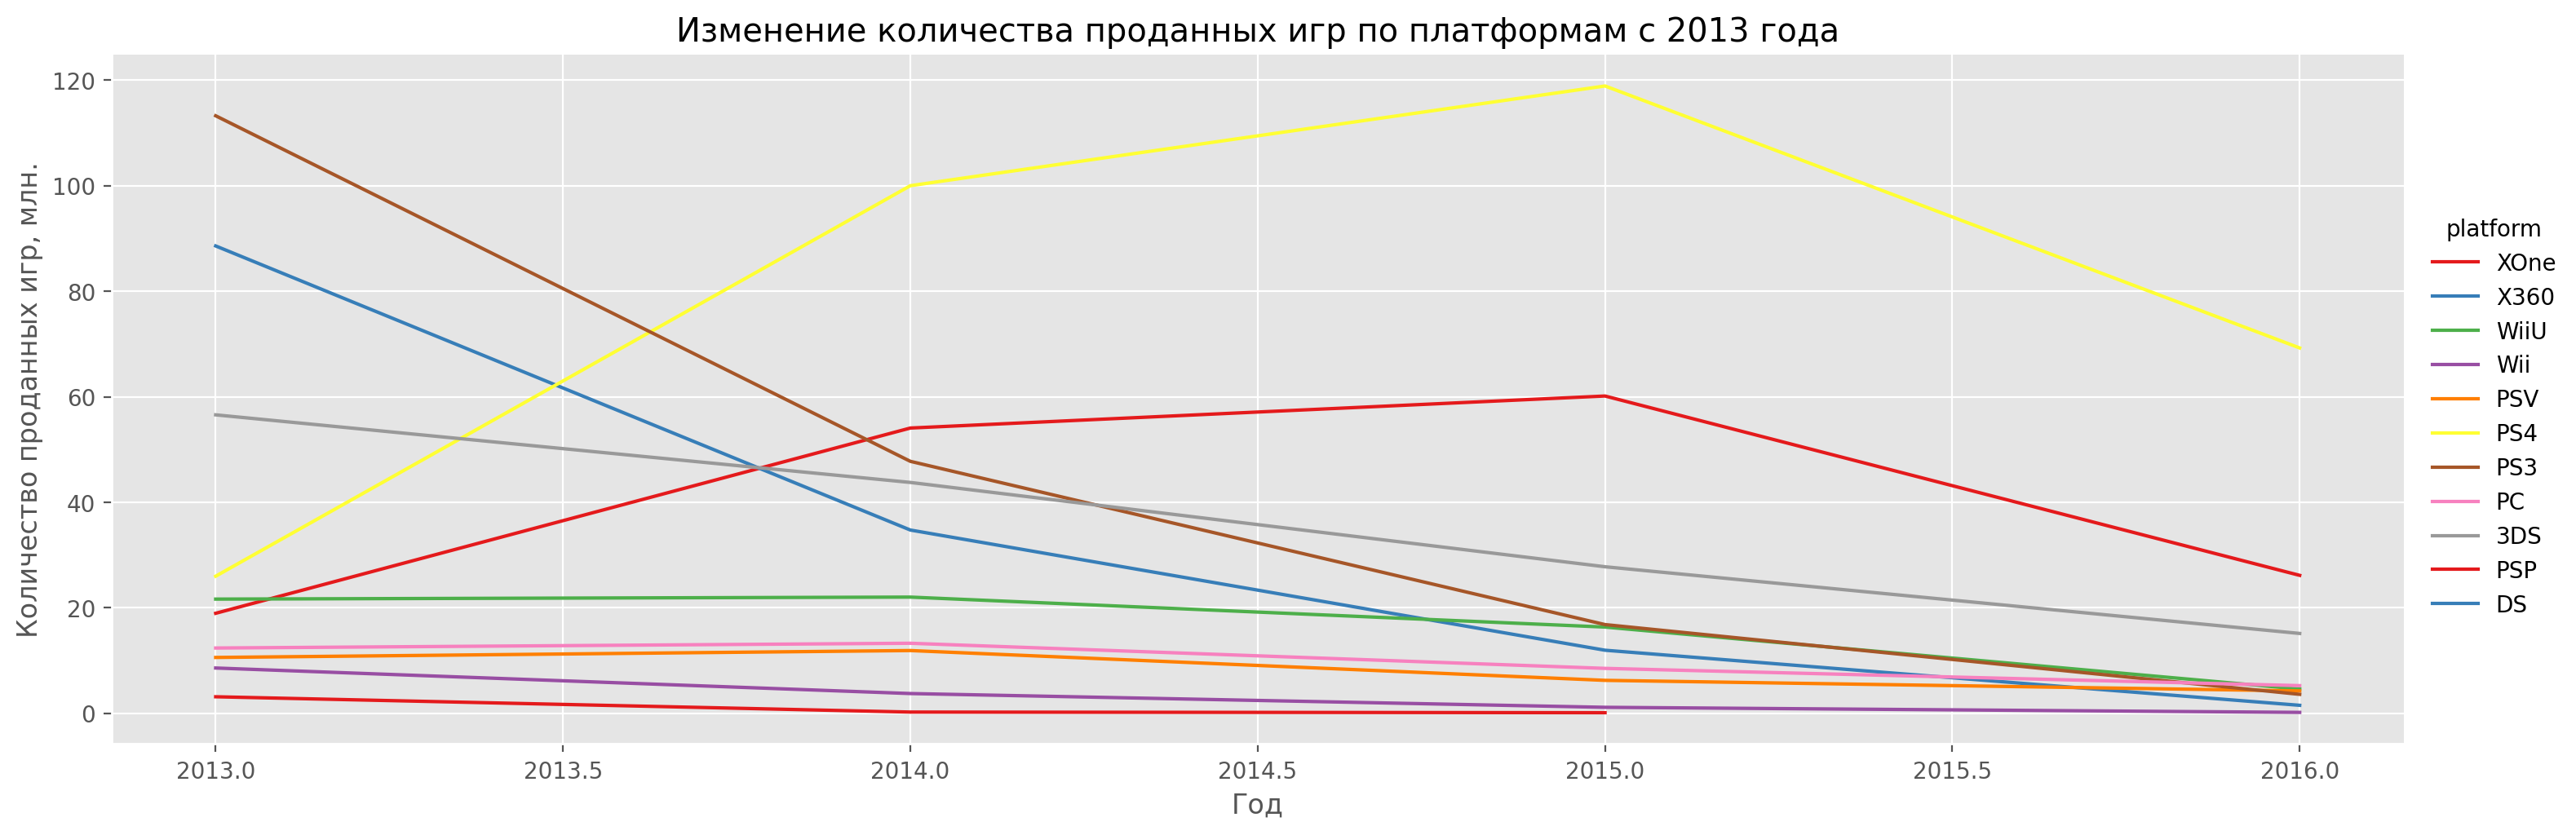

In [86]:
# Изменения продажи игр по платформ в зависимости от года
platform_sales_since_2007 = (df_since_2013.groupby(['year_of_release', 'platform'], as_index=False)
              .agg({'total_sales': 'sum'})
              .sort_values(by='year_of_release', ascending=False))

rel_plot(platform_sales_since_2007, 'year_of_release',
         'total_sales', hue='platform', xlable='Год',
         ylable='Количество проданных игр, млн.',
         title='Изменение количества проданных игр по платформам с 2013 года')

Как видно из графика количествопроданных игр у платформ предыдущего поколения - PS3, 3DS и X360 продажи падают, при этом растут продажи у платформ нового поколения - PS4 и XOne. Так как за 2016 год данные не полные, мы видим небольшое падение в продажах.
Остальные платформы продают не так много игр.

Падение продаж S3, 3DS и X360 можно объяснить сменой поколений игровых платформ. Также, снижения продаж игр на платформах можно объяснить развитием игр на смартфонах. Но, к сожалению, у нас нет данных по играм для мобильных устройств.

Для дальнейшего анализа возьмем платформы PS4 и XOne, как наиболее новые и с большим потенциалом к росту, а также PC, как наиболее долгоиграющего и стабильного игрока. Также возьмем WiiU, так как эта платформа относится к тому же поколению, что и  PS4 и XOne.

In [87]:
# отфильтруем данные только для платформ PS4, XOne,  PC и WiiU.
latest_platforms = df_since_2013.query('platform in ["PS4", "XOne", "PC", "WiiU"]')
latest_platforms

name platform  \
31                         Call of Duty: Black Ops 3      PS4   
42                                Grand Theft Auto V      PS4   
77                                           FIFA 16      PS4   
87                      Star Wars Battlefront (2015)      PS4   
92                    Call of Duty: Advanced Warfare      PS4   
...                                              ...      ...   
16645                                         ZombiU     XOne   
16652                               Fast Racing Neo      WiiU   
16660                               Prison Architect     XOne   
16672  Metal Gear Solid V: The Definitive Experience     XOne   
16692              Metal Gear Solid V: Ground Zeroes       PC   

       year_of_release    genre  na_sales  eu_sales  jp_sales  other_sales  \
31                2015  Shooter      6.03      5.86      0.36         2.38   
42                2014   Action      3.96      6.31      0.38         1.97   
77                2015   Sports      1.12      6.12      0.06         1.28   
87                2015  Shooter      2.99      3.49      0.22         1.28   
92                2014  Shooter      2.81      3.48      0.14         1.23   
...                ...      ...       ...       ...       ...          ...   
16645             2016   Action      0.00      0.01      0.00         0.00   
16652             2016   Action      0.00      0.01      0.00         0.00   
16660             2016   Action      0.01      0.00      0.00         0.00   
16672             2016   Action      0.01      0.00      0.00         0.00   
16692             2014   Action      0.00      0.01      0.00         0.00   

       critic_score  user_score rating  total_sales  
31              0.0         0.0     RP        14.63  
42             97.0         8.3      M        12.62  
77             82.0         4.3      E         8.58  
87              0.0         0.0     RP         7.98  
92             83.0         5.7      M         7.66  
...             ...         ...    ...          ...  
16645           0.0         0.0     RP         0.01  
16652          81.0         8.5      E         0.01  
16660          74.0         6.7     RP         0.01  
16672           0.0         0.0      M         0.01  
16692          80.0         7.6      M         0.01  

[943 rows x 12 columns]

In [88]:
# Средние цифры по платформам
dscrp = []
for i in ["PS4", "XOne", "PC", "WiiU"]:
  dscrp.append(latest_platforms.query(f'platform == "{i}"').total_sales.describe())

dscrp_df = pd.DataFrame(dscrp).T
dscrp_df.columns = ["PS4", "XOne", "PC", "WiiU"]
dscrp_df

PS4        XOne          PC        WiiU
count  392.000000  247.000000  189.000000  115.000000
mean     0.801378    0.645020    0.208624    0.562000
std      1.609456    1.036139    0.352304    1.038778
min      0.010000    0.010000    0.010000    0.010000
25%      0.060000    0.060000    0.030000    0.060000
50%      0.200000    0.220000    0.080000    0.200000
75%      0.730000    0.685000    0.230000    0.595000
max     14.630000    7.390000    3.050000    7.090000

- Количество выпущенных игр наибольшее у PS4 - 392 шт.
- Наблюдается большое стандартное отклонение для платформ, значит, что какие-то игры "выстреливают" и расходятся большими тиражами.
- Медианы проданных игр для платформ примерно на одном уровне - 0.2-0.22. А у PC сильно меньше - 0.08. Что говорит, что на PC покупают игры менее охотно.

[]

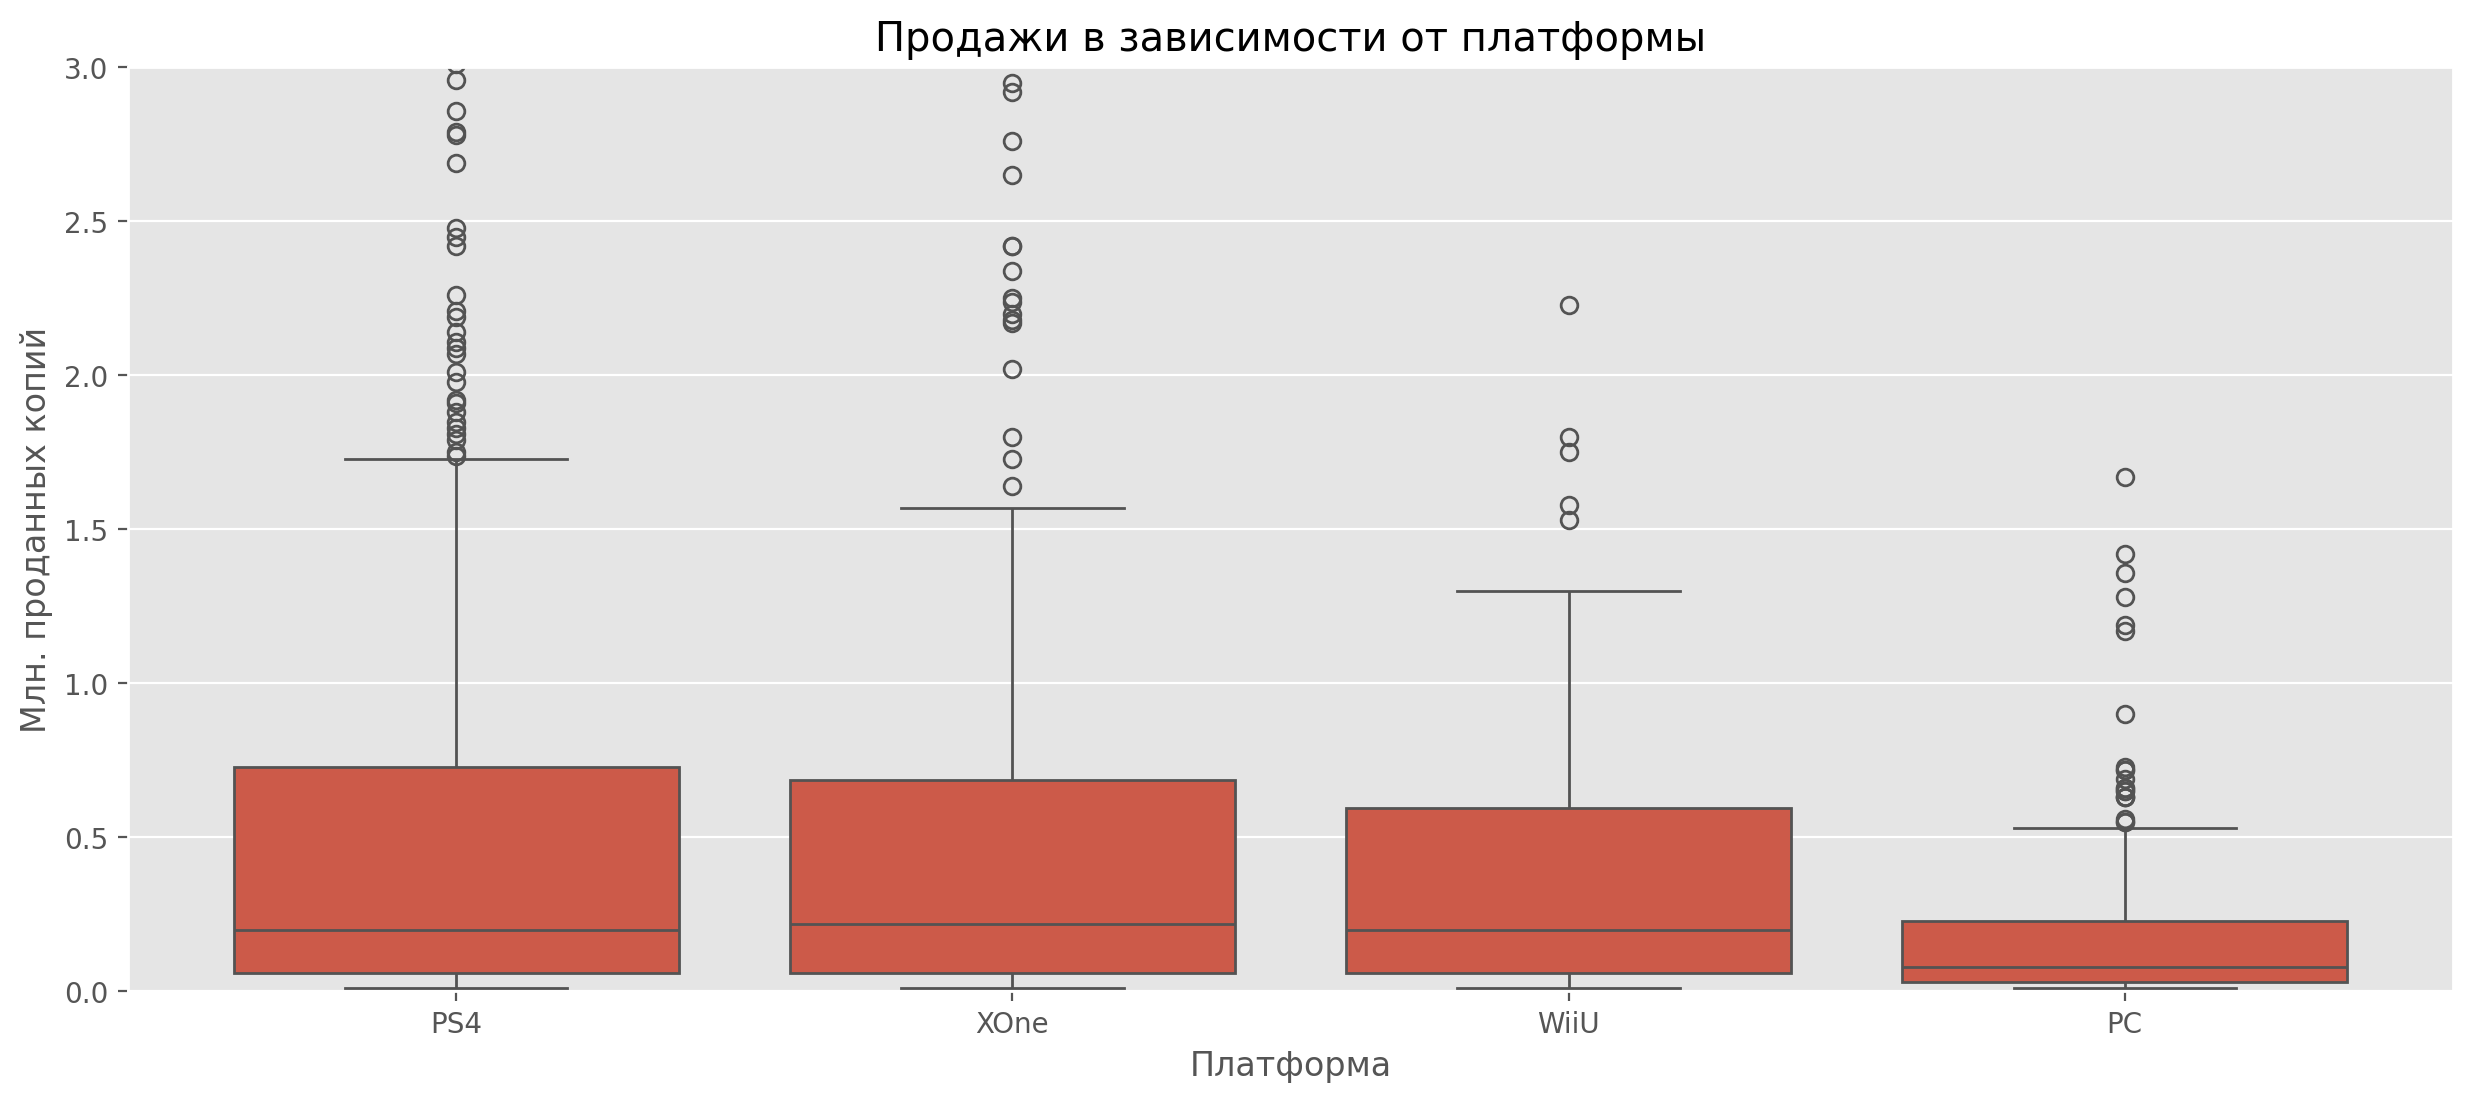

In [89]:
# Глобальные продажи игр в разбивке по платформам.
sns.boxplot(data=latest_platforms, x='platform', y='total_sales')
plt.xlabel('Платформа')
plt.ylabel('Млн. проданных копий')
plt.title('Продажи в зависимости от платформы')
plt.ylim(0, 3)
plt.plot()

По глобальным продажам игр в разбивке по платформам можно сказать, что в среднем игровые платформы (PS, Xbox и Wii) продают одинаковое количество игр. Wii - чуть меньше, так как 3 квартиль "ящика с усами" находится чуть ниже двух остальных. Также существуют большее количество успешных игр, которые расходятся большими тиражами. На графике они обозначаются, как "выбросы".

### Влияние на продажи внутри одной популярной платформы отзывы пользователей и критиков

In [90]:
# убираем 0-е отзывы
latest_platforms_filtered = latest_platforms.query('user_score > 0 and critic_score > 0')

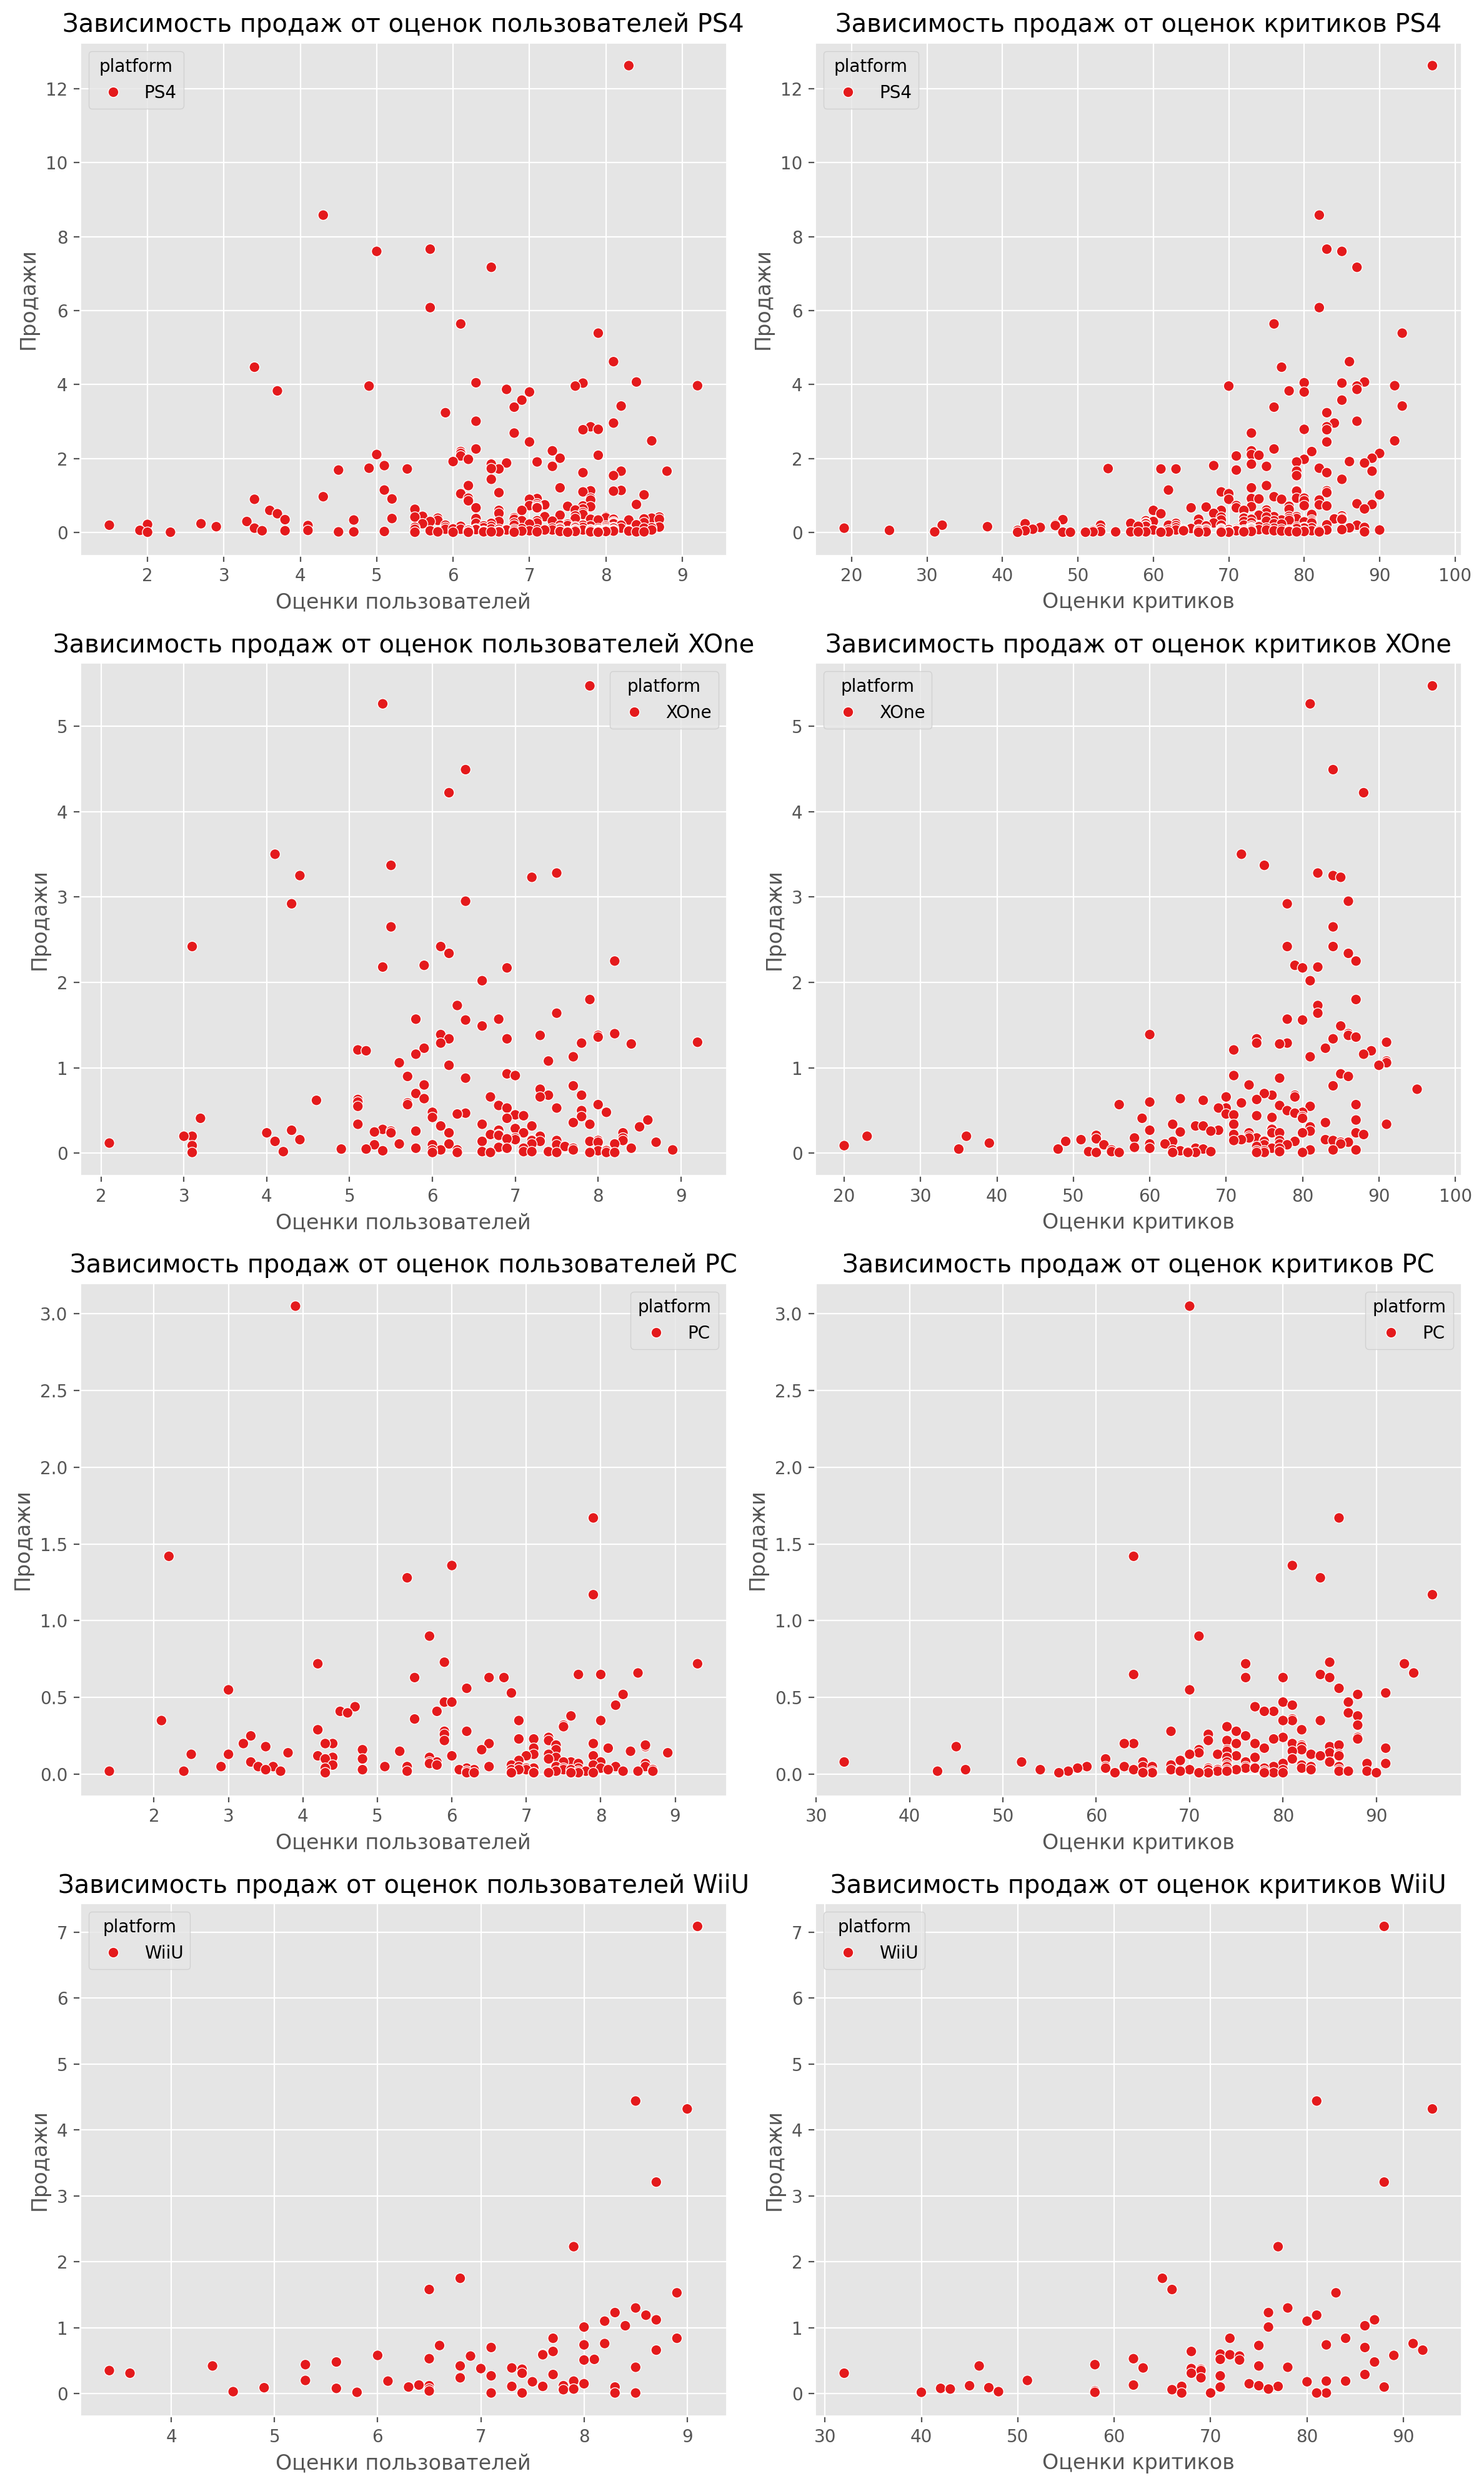

In [91]:
platforms = ["PS4", "XOne", "PC", "WiiU"]
num_platforms = len(platforms)
fig, axes = plt.subplots(num_platforms, 2, figsize=(12, 5 * num_platforms))

for i, platform in enumerate(platforms):
    # Фильтруем данные для текущей платформы
    platform_data = latest_platforms_filtered.query(f'platform == "{platform}"')

    # График для оценок пользователей
    sns.scatterplot(data=platform_data,
                    x='user_score',
                    y='total_sales',
                    hue='platform', ax=axes[i, 0],
                    palette='Set1')
    axes[i, 0].set_xlabel('Оценки пользователей')
    axes[i, 0].set_ylabel('Продажи')
    axes[i, 0].set_title('Зависимость продаж от оценок пользователей ' + platform)

    # График для оценок критиков
    sns.scatterplot(data=platform_data,
                    x='critic_score',
                    y='total_sales',
                    hue='platform', ax=axes[i, 1],
                    palette='Set1')
    axes[i, 1].set_xlabel('Оценки критиков')
    axes[i, 1].set_ylabel('Продажи')
    axes[i, 1].set_title('Зависимость продаж от оценок критиков ' + platform)

# Настройка отображения графиков
plt.tight_layout()
plt.show()

Анализируя графики рассеяния, можно сделать вывод, что существует неоднозначная связь между высокими оценками и продажами игр. Многие игры с высокими оценками не демонстрируют выдающихся результатов в плане продаж.

Зависимость продаж от оценок пользователей и критиков проявляется по-разному. На графиках рассеяния, отражающих оценки пользователей, точки расположены более равномерно. Это означает, что многие игры с более низкими оценками могут иметь хорошие продажи.

Однако на графиках рассеяния, связанных с оценками критиков, наблюдается смещение в сторону более высоких оценок. Это говорит о том, что большинство игр, у которых оценки критиков выше 70 баллов, имеют хорошие продажи.

Отличие демонстрируют графики для платформы Wii. Графики очень похожи между собой. Видна тенденция - более высокие продажи имеют игры с более высокими оценками.

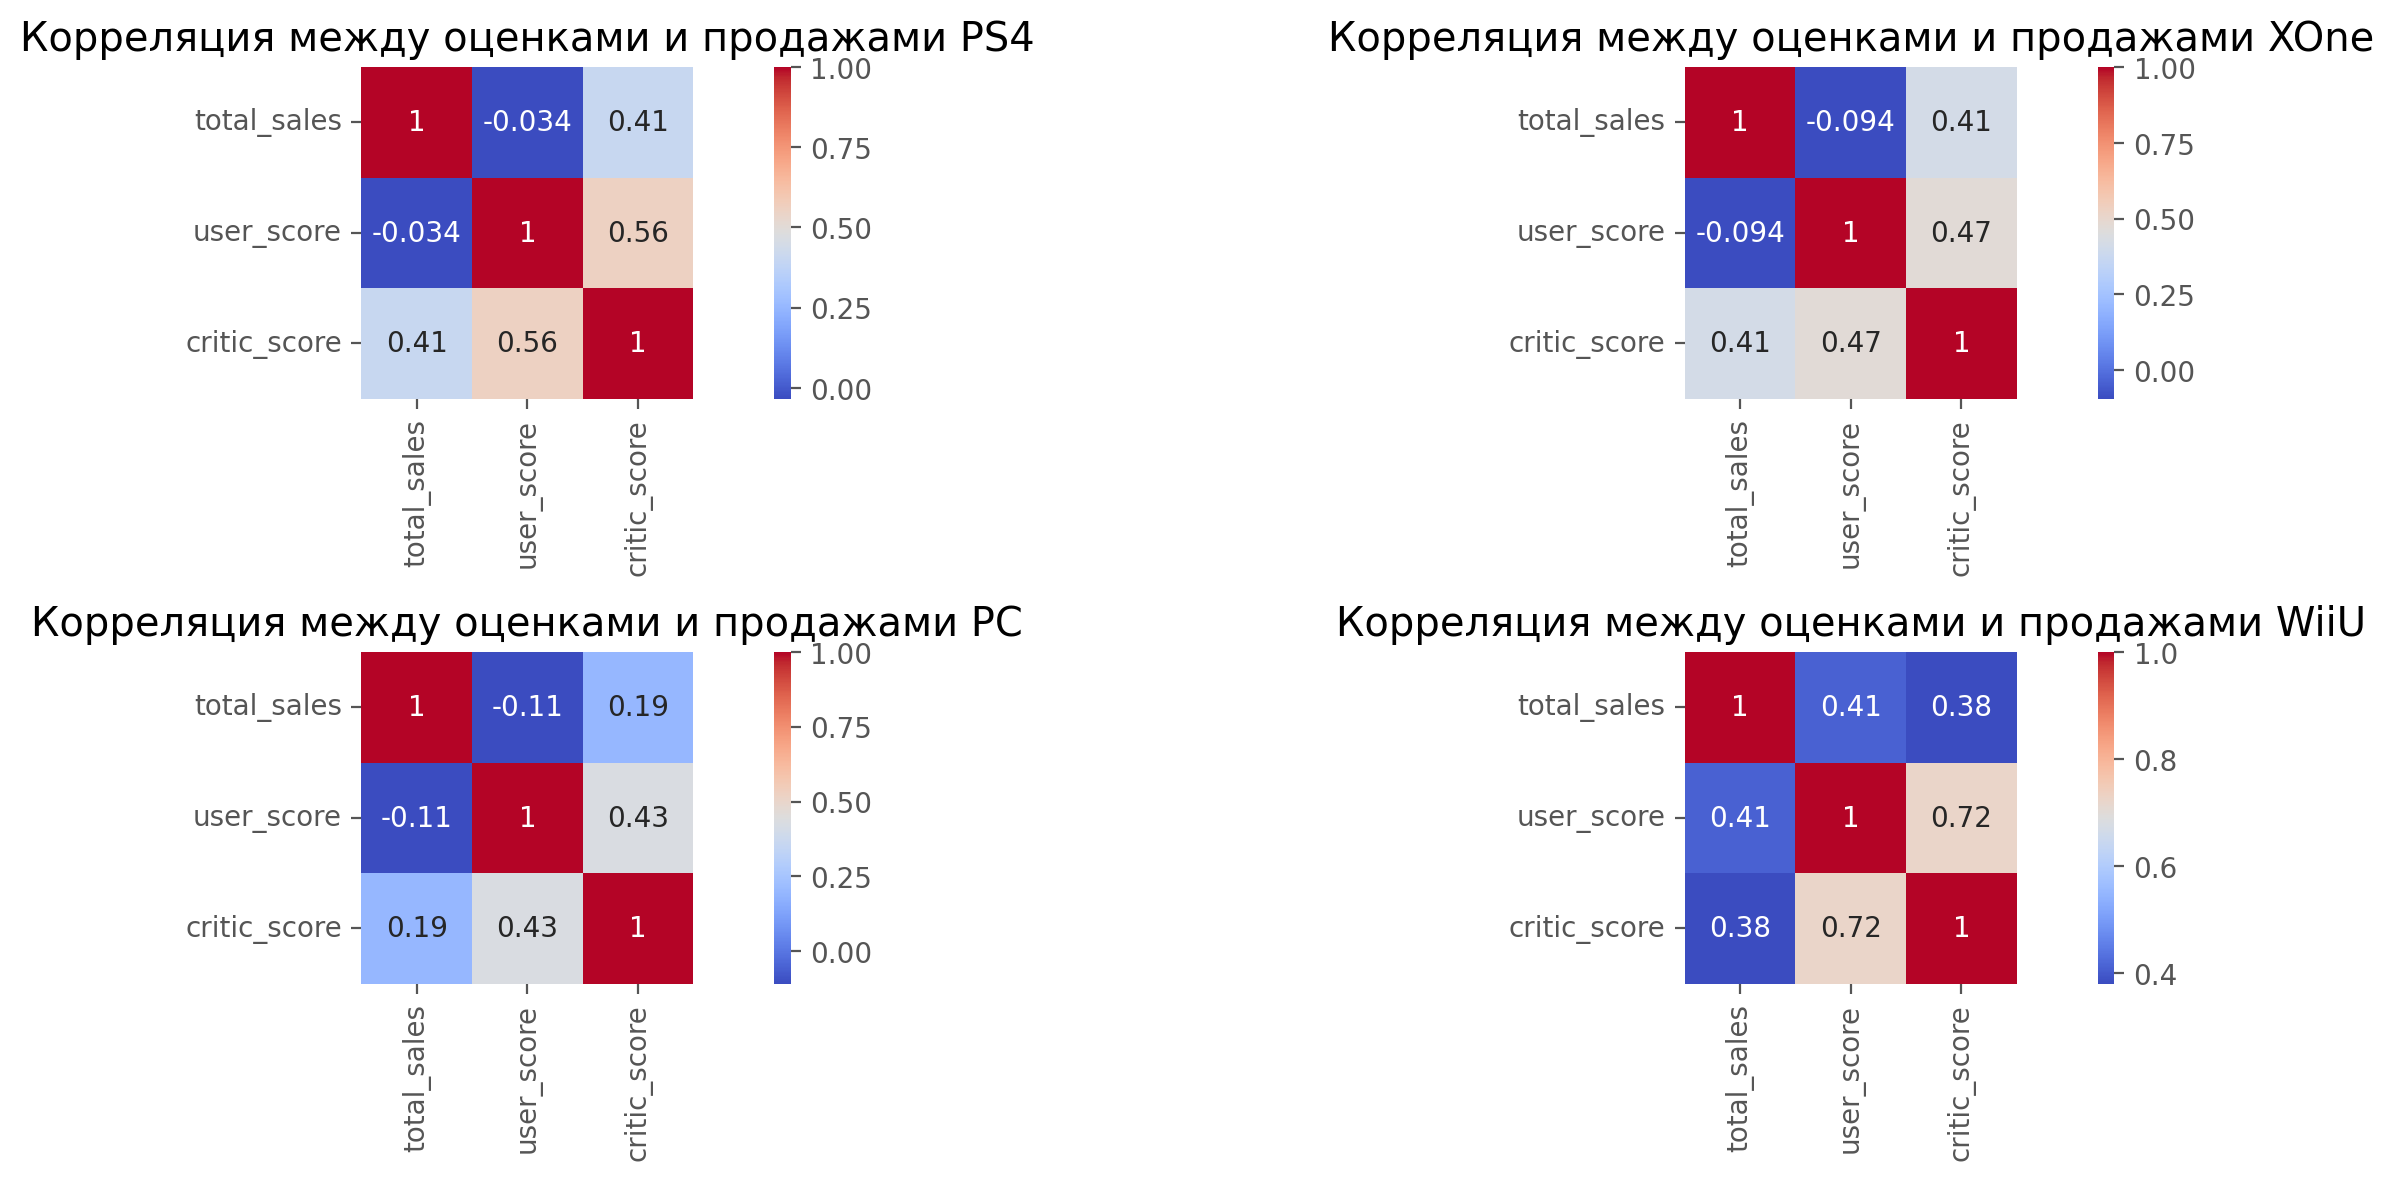

In [92]:
#корреляция между отзывами и продажами
for i, platform in enumerate(platforms, 1):
  plt.subplot(2, 2, i)
  sns.heatmap(
  data=(latest_platforms_filtered.query(f'platform == "{platform}"')
  [['total_sales','user_score', 'critic_score']].corr()),
        annot=True,
        cmap='coolwarm',
        square=True)

  plt.title('Корреляция между оценками и продажами ' + platform)
plt.tight_layout()
plt.show()


Графики корреляции подтверждают данные, полученные из графиков рассеивания. Видна слабая корреляция между оценками критиков и продажами игр 0.38-0.41 для PS4, XOne и Wii. Для PC  - корреляция меньше - 0.19. А связь между оценками пользователей и продажами игр почти отсутствует, за исключением платформы WiiU, где связь между оценками пользователей и продажами несколько выше, чем связь между оценками критиков и продажами.

Отсюда можно сделать вывод, что на момент предоставления данных оценки критиков играли большую роль в продажах игр, чем оценки пользователей.

### Распределение игр по жанрам.

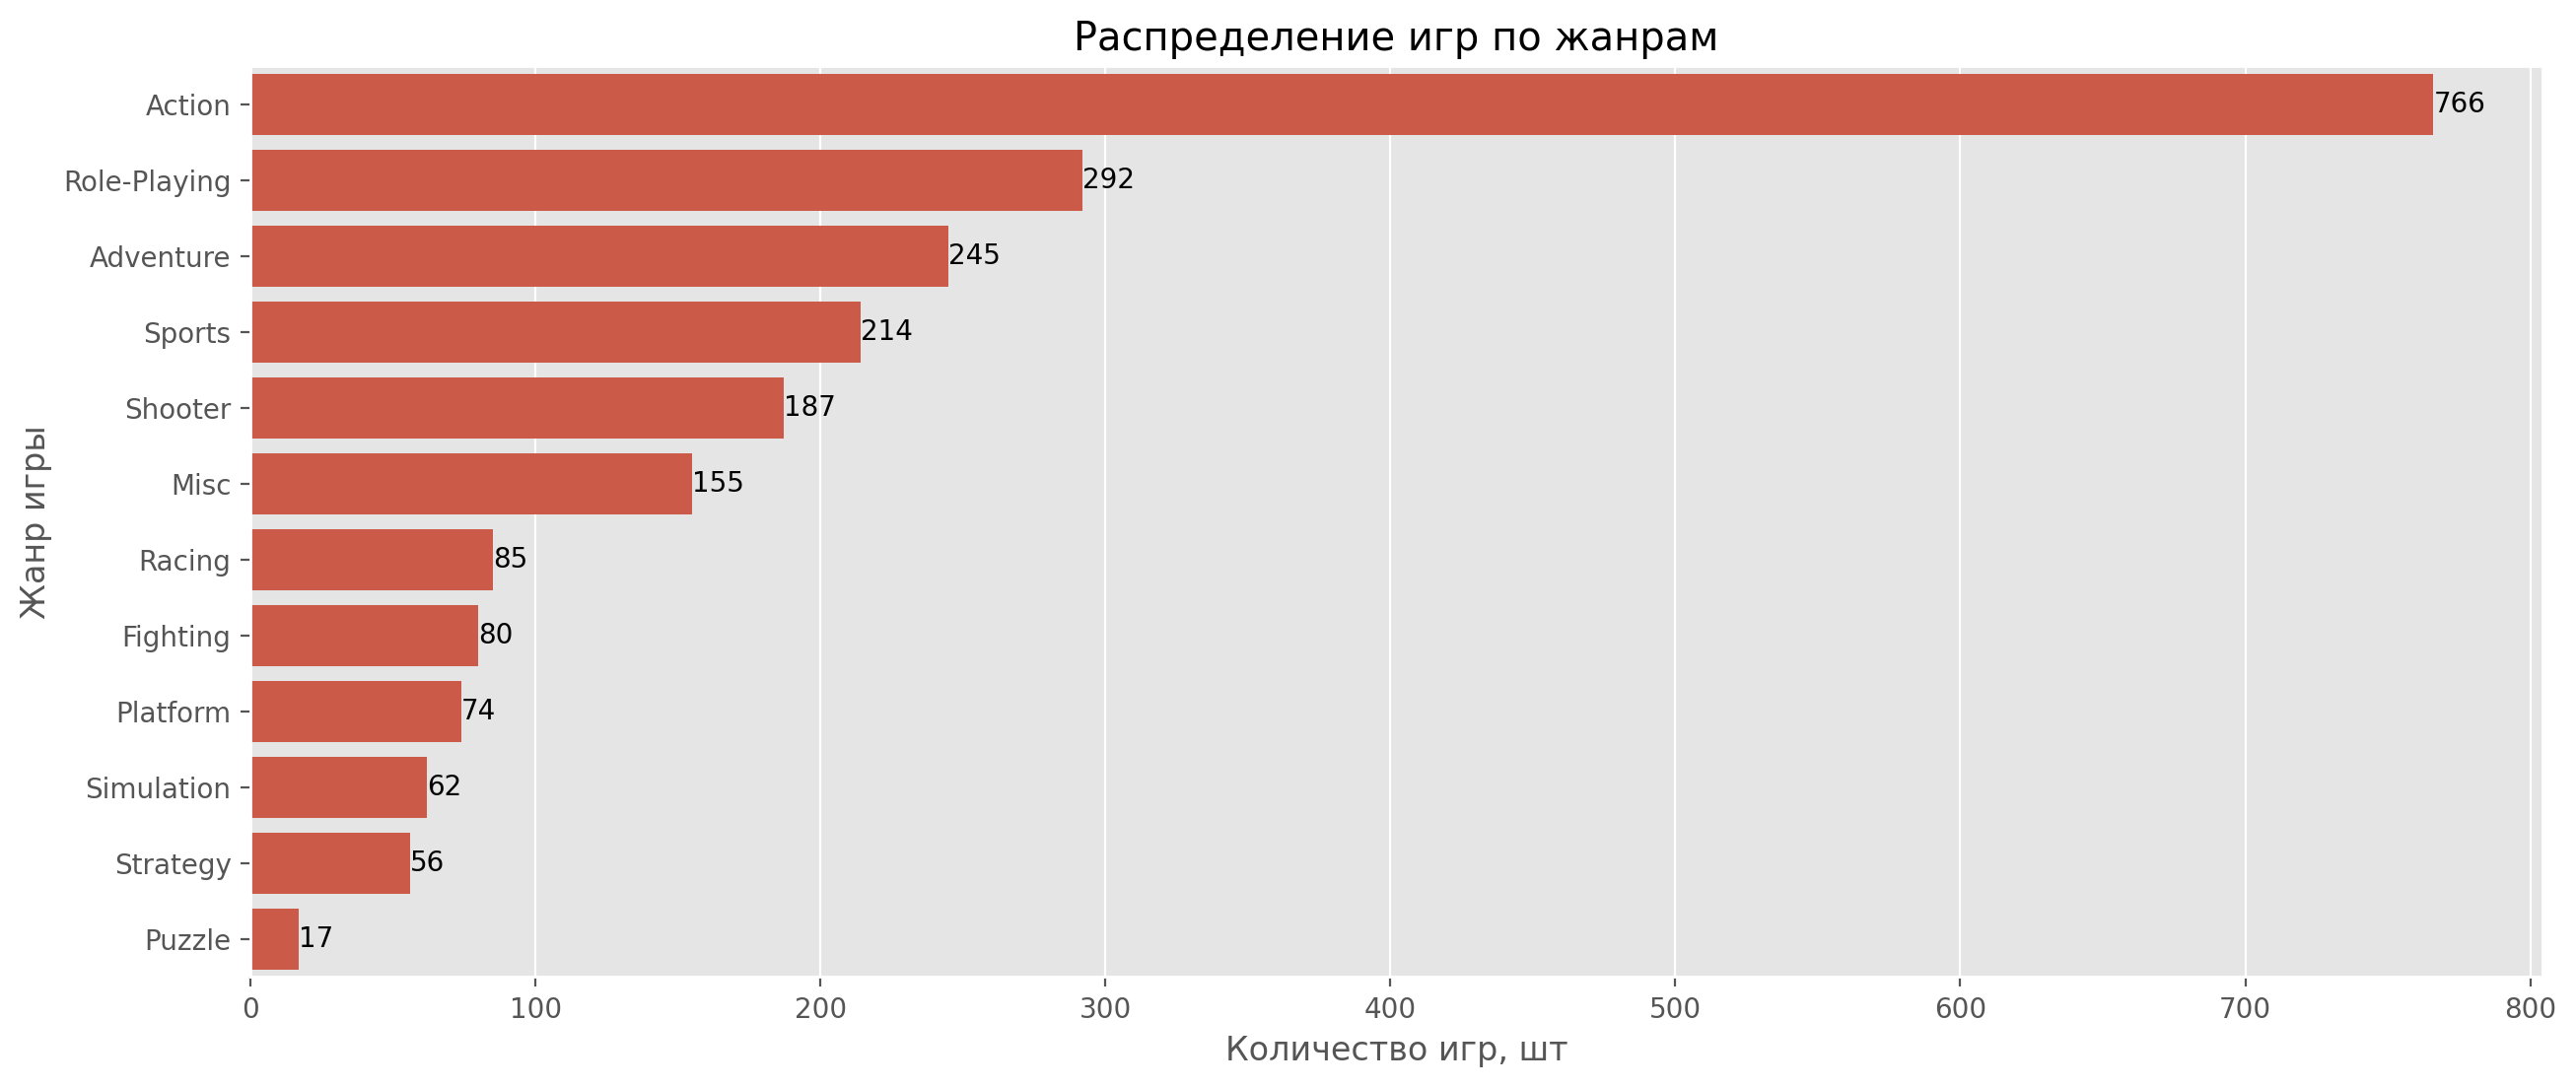

In [93]:
# Распределение игр по жанрам
genres = df_since_2013['genre'].value_counts().reset_index()
bar_plot(genres, 'count', 'genre', 'Количество игр, шт', 'Жанр игры', 'Распределение игр по жанрам')

Как видно, количество игр жанра `Action` более чем в два раза опережает игры жанров `Role-Playing` и `Adventure` - 766 игр против 292 и 245 соответственно. Меньше всего игр жанров `Simulation`, `Strategy` и `Puzzle` - по 62, 56 и 17 шт. соответственно.

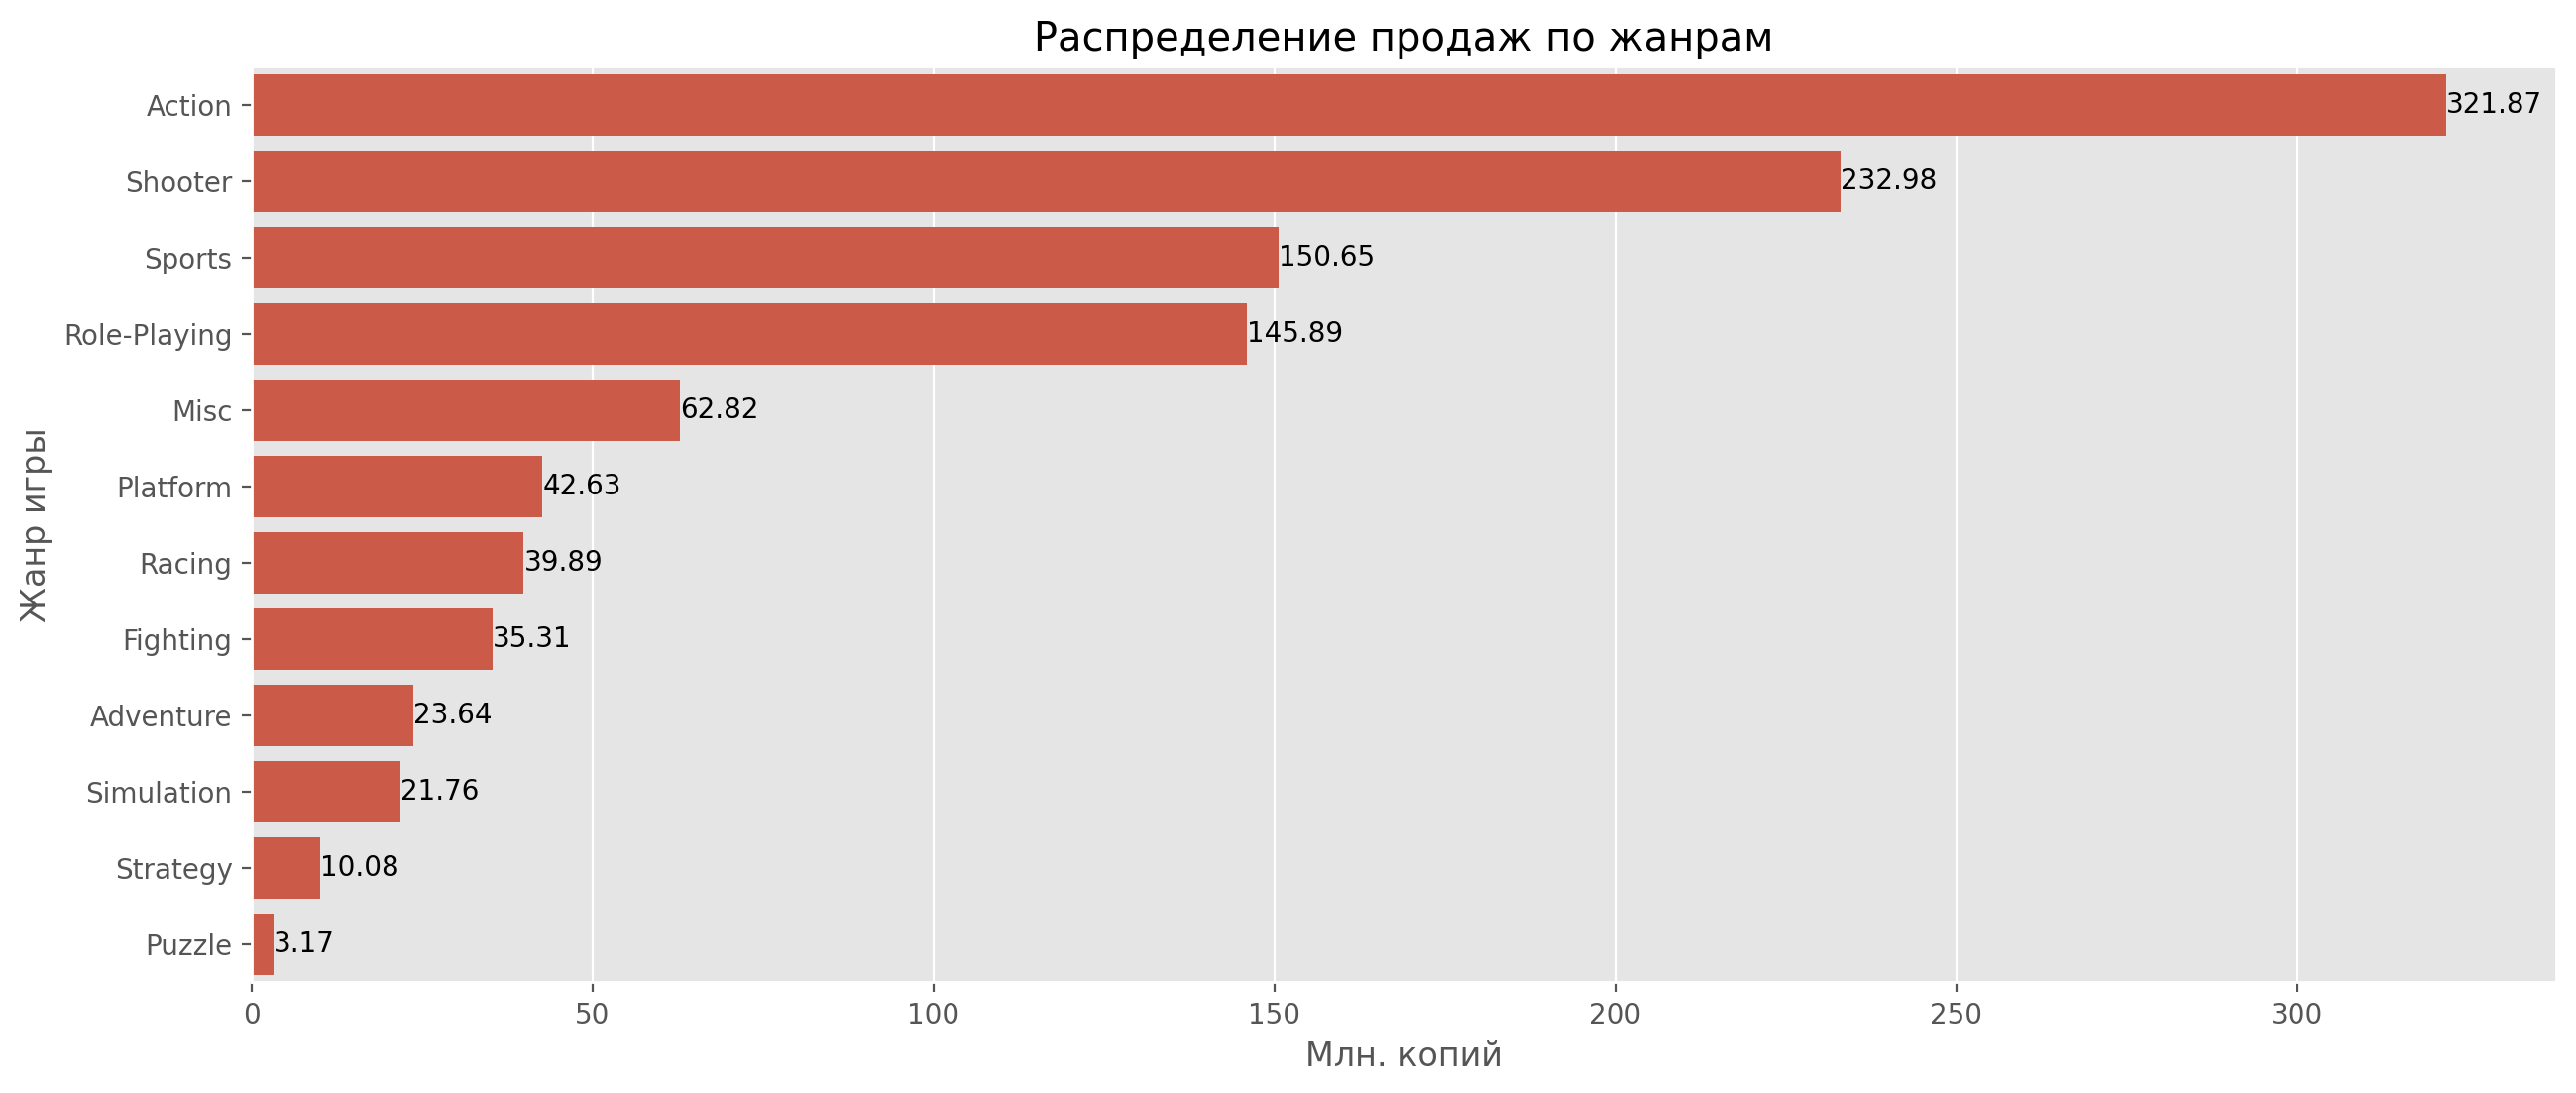

In [94]:
# сгруппируем игры по жанрам и посчитаем продажи
genre_sales = (df_since_2013.groupby('genre')['total_sales']
               .sum()
               .reset_index()
               .sort_values(by='total_sales', ascending=False))
bar_plot(genre_sales, 'total_sales', 'genre', 'Млн. копий', 'Жанр игры', 'Распределение продаж по жанрам')

На первом месте по количеству проданных копий игры жанра `Action` (321.9 млн копий). Второе место заняли игры жанра `Shooter` (233 млн копий). А третье - `Sports` (150.6 млн копий). Наименее продаваемые жанры - `Strategy` и `Puzzle` по 10.08 и 3.17 млн. копий соответственно.

Таким образом:
- Наиболее продаваемый и имеющий наибольшее количество игр - жанр `Action` (игр жанра 766, было продано 321.9 млн. копий).
- На втором месте по количеству игр жанр `Role-Playing` (292 игр), но проданных больше игр жанра `Shooter` - 233 млн. копий. Что значит, что игры жанры Шутер продаются лучше - их всего 187 шт.
- На третьем месте игры жанра `Adventure` - всего игр 245 шт., но проданных больше игр жанра `Sports` (150.6 млн копий).
- Среди аутсайдеров - жанры  `Strategy` и `Puzzle`.

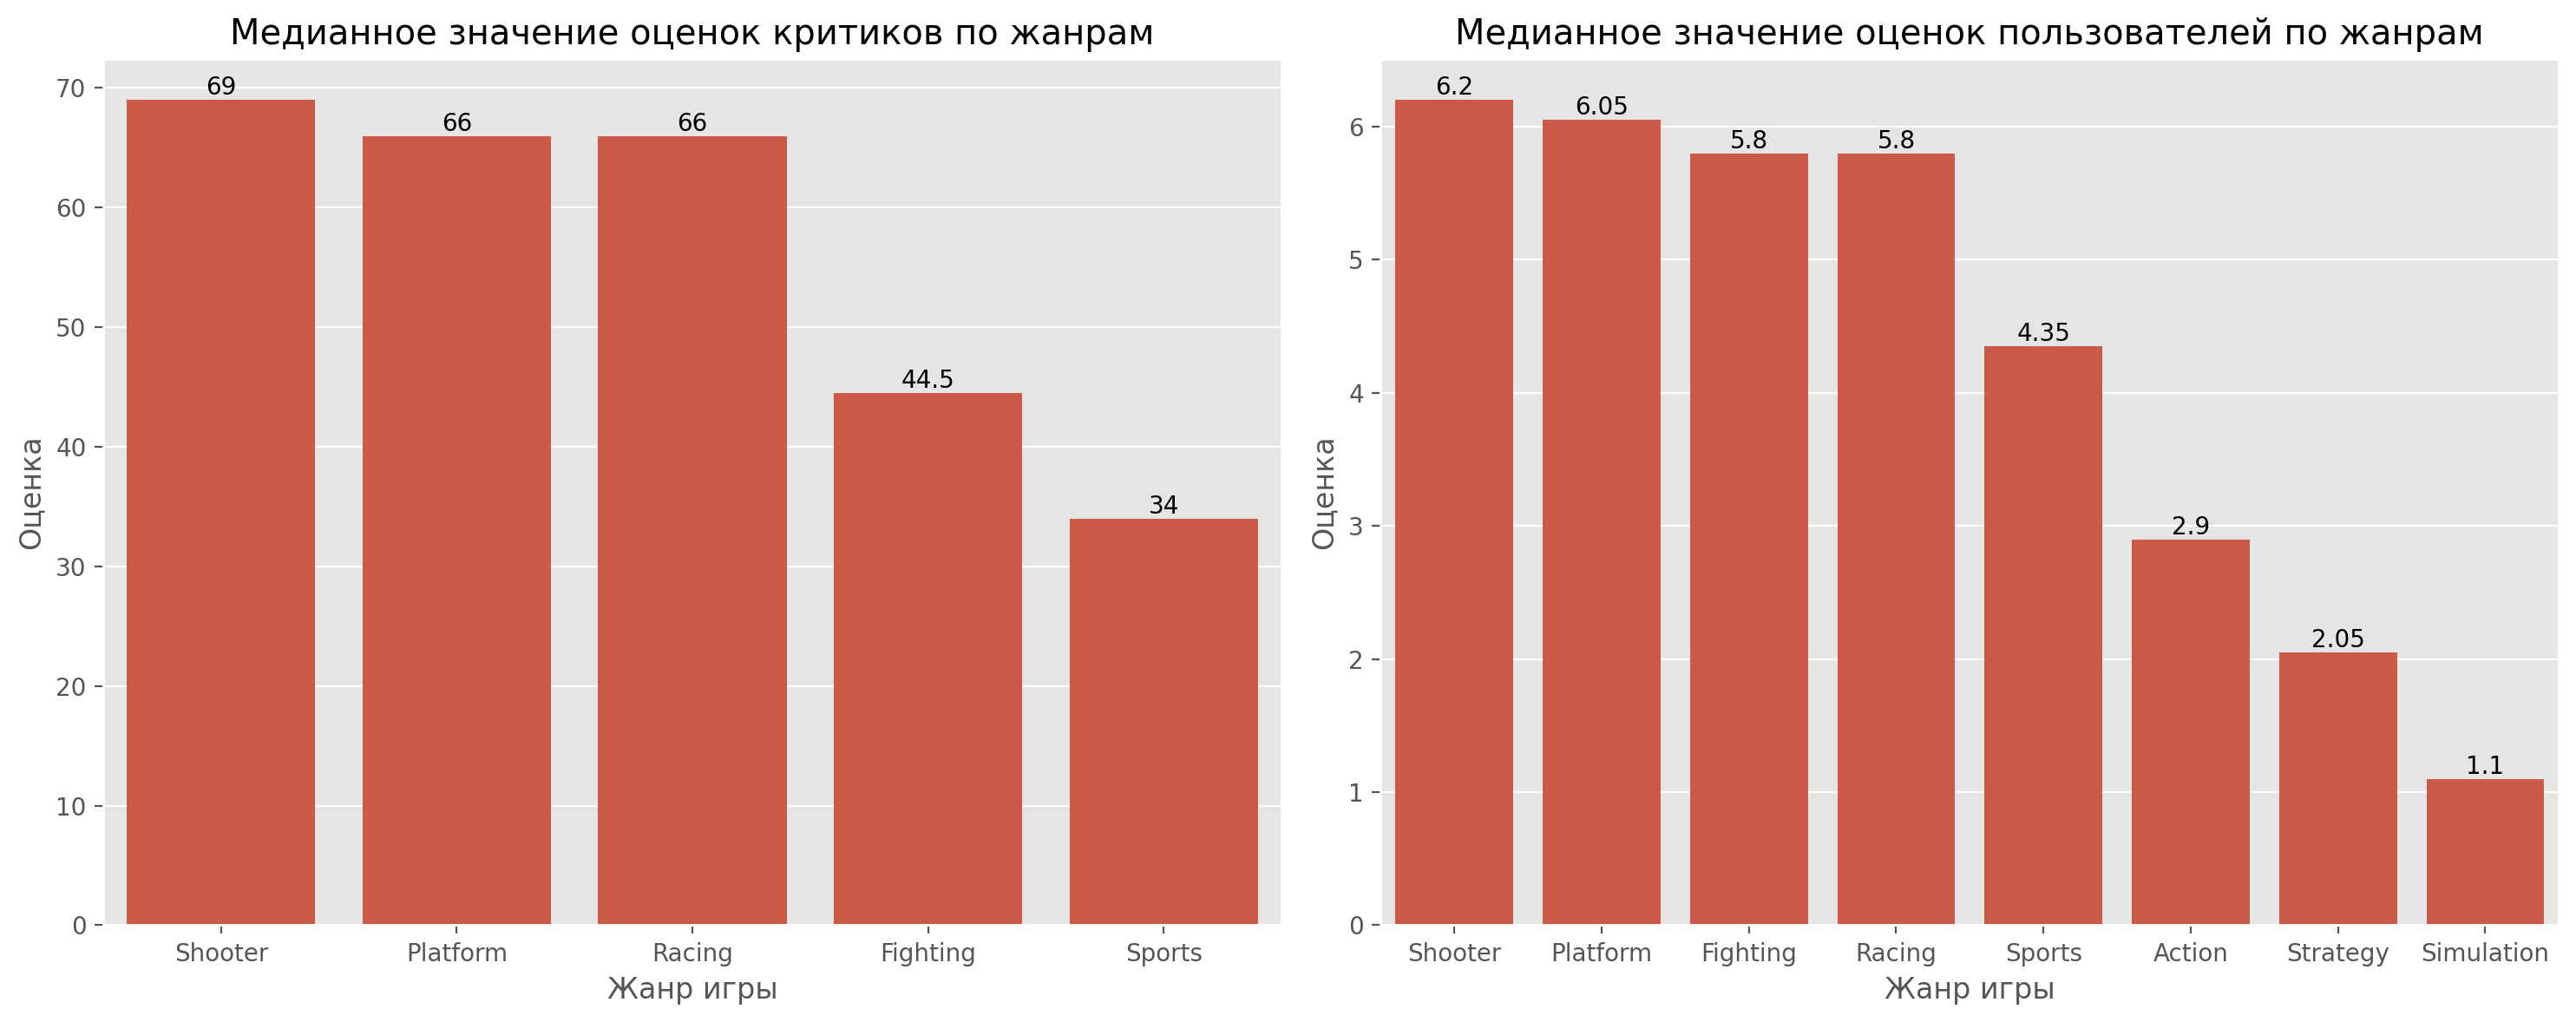

In [95]:
# медианное значение оценок пользователей и критиков по жанрам

critic_median = df_since_2013.groupby('genre')['critic_score'].median().reset_index()
user_median = df_since_2013.groupby('genre')['user_score'].median().reset_index()
critic_median = critic_median.sort_values(by='critic_score', ascending=False)
user_median = user_median.sort_values(by='user_score', ascending=False)

# убираем 0-е отзывы
critic_median = critic_median.query('critic_score > 0')
user_median = user_median.query('user_score > 0')
# построим графики распределения оценок в зависимости от жанров

plt.subplot(1, 2, 1)
ax = sns.barplot(data=critic_median, x='genre', y='critic_score')
plt.title('Медианное значение оценок критиков по жанрам')
plt.xlabel('Жанр игры')
plt.ylabel('Оценка')
ax.bar_label(ax.containers[0])

plt.subplot(1, 2, 2)
ax = sns.barplot(data=user_median, x='genre', y='user_score')
plt.title('Медианное значение оценок пользователей по жанрам')
plt.xlabel('Жанр игры')
plt.ylabel('Оценка')
ax.bar_label(ax.containers[0])

plt.tight_layout()
plt.show()

Критики и пользователи сошлись во мнении, что игры жанра `Shooter` несколько лучше остальных. На втором месте игры жанра `Platform`. У критиков замыкающим идут игры жанры `Sports`. Пользователи поставили оценок больше и у данной группы замыкают рейтинг игры жанров `Strategy` и `Simulation`.

Краткий вывод по этой части:
- До 1991 года игр выпускалось немного. После 1991 наблюдается увеличение их количества.
- Продолжительность "жизни" платформ из топ 10 по продажам составляет примерно 9 лет. А среди худших по продажам -  5.1 лет с медианой 3.5 лет.
- PS4, XOne и WiiU - новые платформы на период 2016 года. Для них наблюдался рост продаж игр.
- Самая долгоживущая платформа - PC - 24 года (на момент 2016 года).
- в среднем игровые платформы последнего поколения (PS, Xbox и Wii) продают одинаковое количество игр (Wii - чуть меньше).
- Есть слабая корреляция между оценками критиков и продажами игр 0.38-0.41. А связь между оценками пользователей и продажами игр почти отсутствует, за исключением платформы WiiU, где связь между оценками пользователей и продажами несколько выше (0.41), чем связь между оценками критиков и продажами (0.38).
- Наиболее продаваемым и имеющим наибольшее количество игр является жанр `Action` (игр жанра 766, было продано 321.9 млн. копий). Среди аутсайдеров - жанры  `Strategy` и `Puzzle`.
- Критики и пользователи сошлись во мнении, что игры жанра `Shooter` лучше остальных.


## Портрет пользователя каждого региона

### Самые популярные платформы каждого региона (NA, EU, JP) (топ-5)

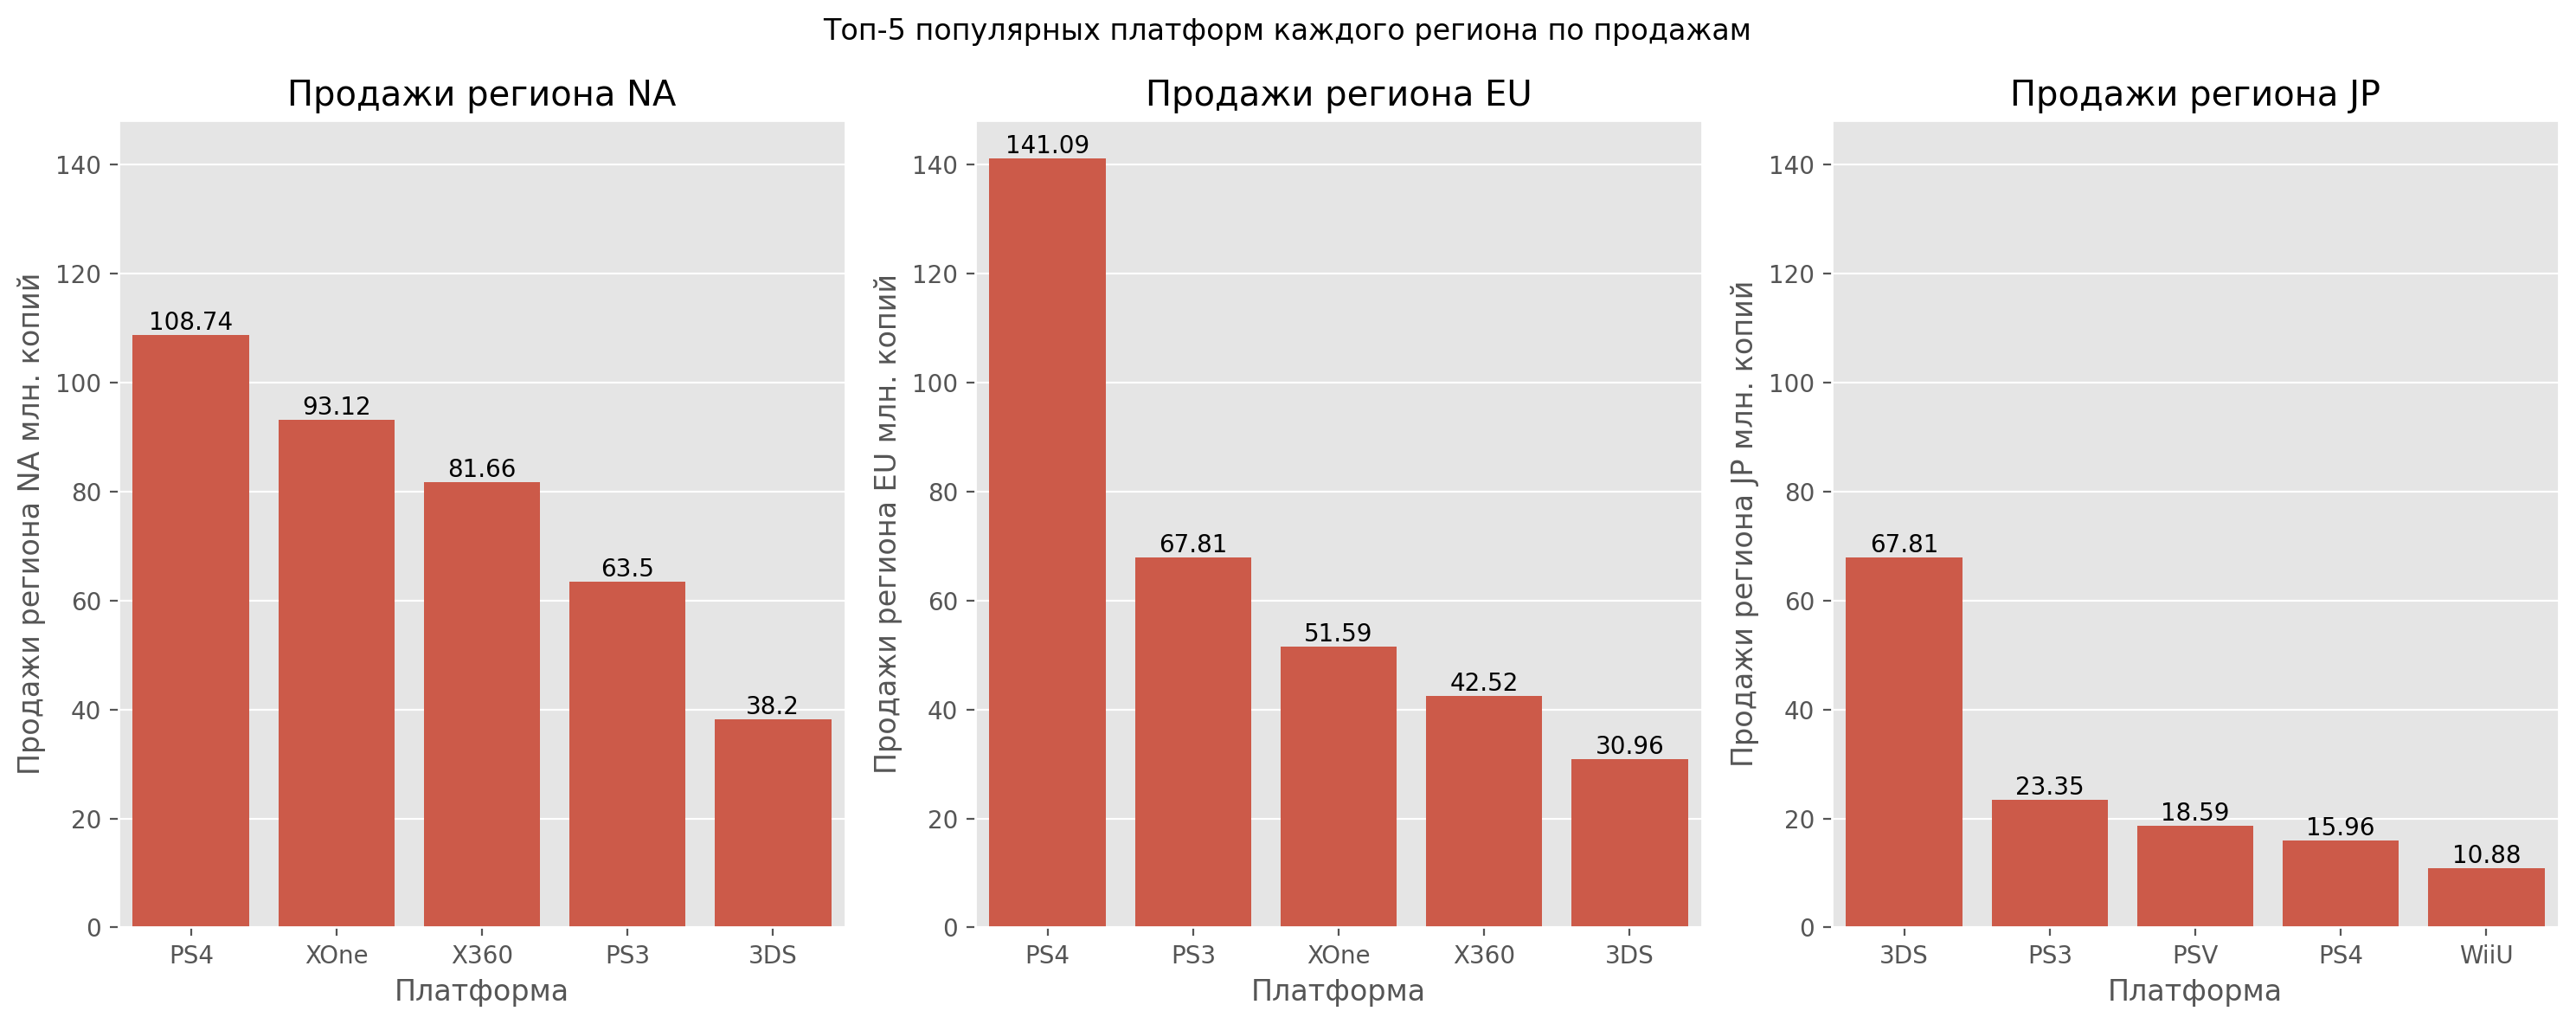

In [96]:
# Выведем регионы в отдельную переменную
regions_sales = ([('na_sales', 'Продажи региона NA'),
                  ('eu_sales', 'Продажи региона EU'),
                  ('jp_sales', 'Продажи региона JP')])

# запустим цикл с построением графиков
for i, regions in enumerate(regions_sales, 1):
   plt.subplot(1, 3, i, sharey=ax)
   ax = sns.barplot(data=(df_since_2013
                     .groupby('platform', as_index=False)[regions[0]]
                     .sum()
                     .sort_values(by=regions[0], ascending=False)
                     .head(5)),
               x='platform',
               y=regions[0]
   )
   ax.bar_label(ax.containers[0])
   ax.set_xlabel('Платформа')
   ax.set_ylabel(regions[1] + ' млн. копий')
   ax.set_title(regions[1])

plt.suptitle('Топ-5 популярных платформ каждого региона по продажам')
plt.tight_layout()
plt.show()


- Наиболее популярная платформа в регионе NA - PS4 (108.74 млн. копий). На последнем месте по продажам - 3DS (38.20 млн. копий).
- В регионе EU наиболее популярны игры также на платформе PS4 (141.09 млн. копий). На втором месте - PS3 - это значит, что пользователи из этого региона предпочитают платформы от коипании Sony больше других платформ. На последнем месте платформа 3DS (продано 30.96 млню копий).
- В регионе JP предпочитают карманное устройство - 3DS - по 67.81 копий игр. На последнем месте WiiU - 10.88 млн. копий. Примечательно, что платформы X360 нет в топе 5. А все представленные платформы являются домашней продукцией.

### Самые популярные жанры (топ-5)

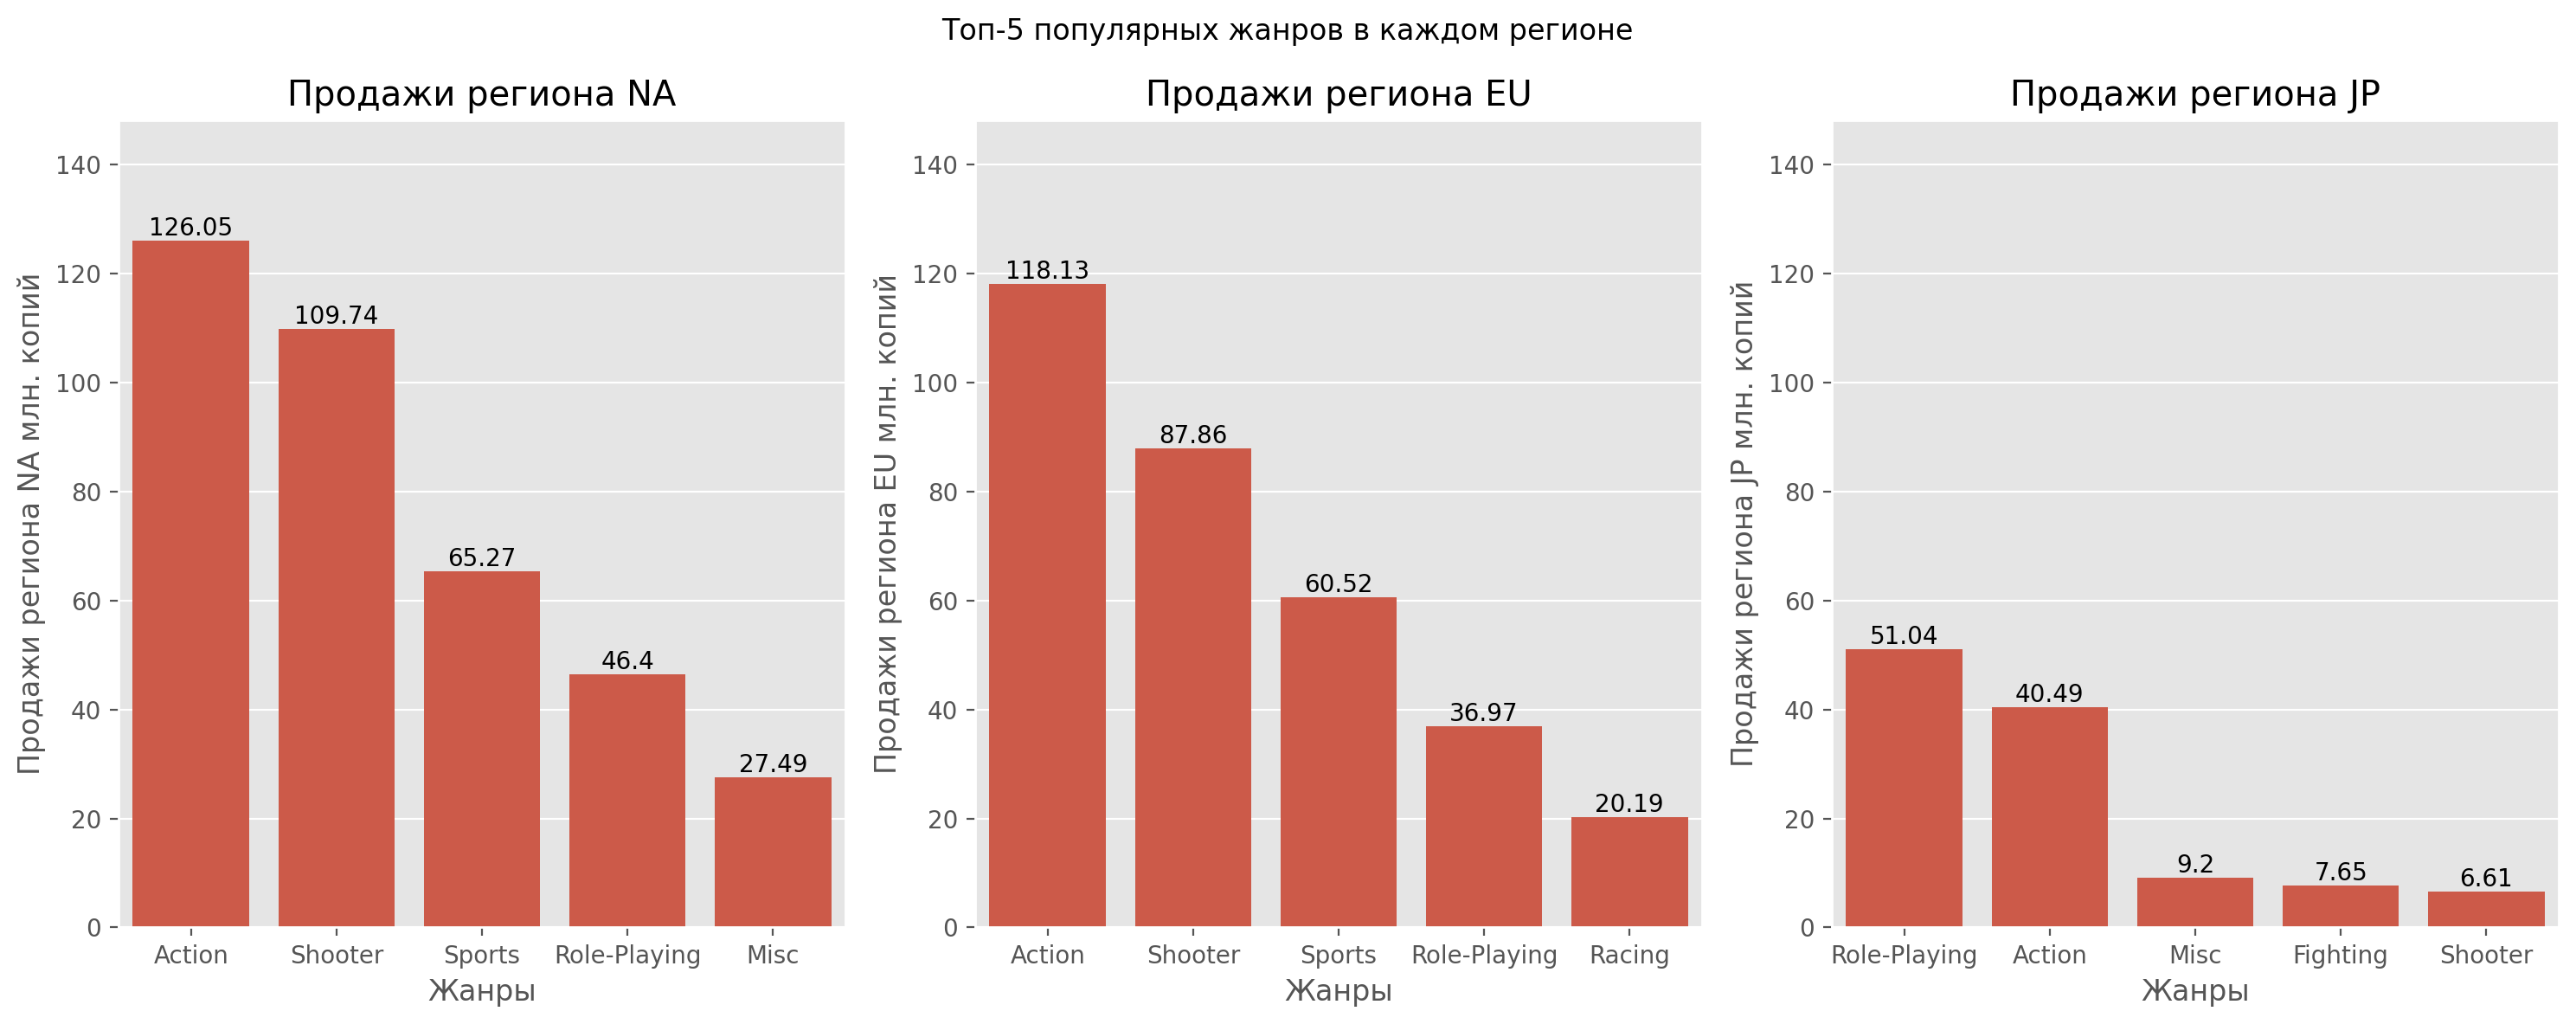

In [97]:
# Выведем регионы в отдельную переменную
regions_sales = ([('na_sales', 'Продажи региона NA'),
                  ('eu_sales', 'Продажи региона EU'),
                  ('jp_sales', 'Продажи региона JP')])
# запустим цикл с построением графиков
for i, regions in enumerate(regions_sales, 1):
   plt.subplot(1, 3, i, sharey=ax)
   ax = sns.barplot(data=(df_since_2013
                     .groupby('genre', as_index=False)[regions[0]]
                     .sum()
                     .sort_values(by=regions[0], ascending=False)
                     .head(5)),
               x='genre',
               y=regions[0]
   )
   ax.bar_label(ax.containers[0])
   ax.set_xlabel('Жанры')
   ax.set_ylabel(regions[1] + ' млн. копий')
   ax.set_title(regions[1])

plt.suptitle('Топ-5 популярных жанров в каждом регионе')
plt.tight_layout()
plt.show()


- Наибольшие сборы характерны для региона NA.
- Топ 4 жанров регионов NA и EU одинаковые, что говорит об одинаковых предпочтениях в играх.
- Жанры в регионе JP довольно сильно отличаются. На первом месте здесь `Role-Playing` (51.04 млн. копий) и только на втором месте `Action`, хотя в двух других регионах этот жанр был Топ-1.
- Такое различие в предпочитаемых жанрах объясняется используемой платформой для игр. В Регионе JP предпочитают небольшие переносные платформы, на которых удобно играть в игры жанра `Role-Playing` и `Action`. Но в шутеры и спортивные игры играть не удобно.

### Влияние ли рейтинга ESRB на продажи в отдельном регионе?

In [98]:
# сгруппируем данные по рейтингум и посчитаем продажи для каждого региона
df_since_2013.head()

name platform  year_of_release         genre  \
16         Grand Theft Auto V      PS3             2013        Action   
23         Grand Theft Auto V     X360             2013        Action   
31  Call of Duty: Black Ops 3      PS4             2015       Shooter   
33        Pokemon X/Pokemon Y      3DS             2013  Role-Playing   
42         Grand Theft Auto V      PS4             2014        Action   

    na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
16      7.02      9.09      0.98         3.96          97.0         8.2   
23      9.66      5.14      0.06         1.41          97.0         8.1   
31      6.03      5.86      0.36         2.38           0.0         0.0   
33      5.28      4.19      4.35         0.78           0.0         0.0   
42      3.96      6.31      0.38         1.97          97.0         8.3   

   rating  total_sales  
16      M        21.05  
23      M        16.27  
31     RP        14.63  
33     RP        14.60  
42      M        12.62

Посчитаем отношение количества проданных игр к количеству игр определенного рейтинга.

In [99]:
# объявим переменную, в которой группируем по рейтингу продажи в разных регионах
# и посчитаем количество игр по регионам
# отфильтруем неопределенный рейтинг
sales_per_rating = (df_since_2013
                    .query('rating != "RP"')
                    .groupby('rating', as_index=False)
                    [['na_sales','eu_sales','jp_sales', 'name']]
                    .agg({'na_sales':'sum',
                          'eu_sales':'sum',
                          'jp_sales':'sum',
                          'name':'count'}))
# посчитаем отношение проданных игр в регионе ко всем проданным играм определенного рейтинга
sales_per_rating['na_sales'] = round(sales_per_rating['na_sales'] / sales_per_rating['name'],2)
sales_per_rating['eu_sales'] = round(sales_per_rating['eu_sales'] / sales_per_rating['name'],2)
sales_per_rating['jp_sales'] = round(sales_per_rating['jp_sales'] / sales_per_rating['name'],2)
sales_per_rating

rating  na_sales  eu_sales  jp_sales  name
0      E      0.26      0.28      0.05   302
1   E10+      0.22      0.17      0.02   252
2      M      0.45      0.39      0.04   369
3      T      0.15      0.13      0.06   333

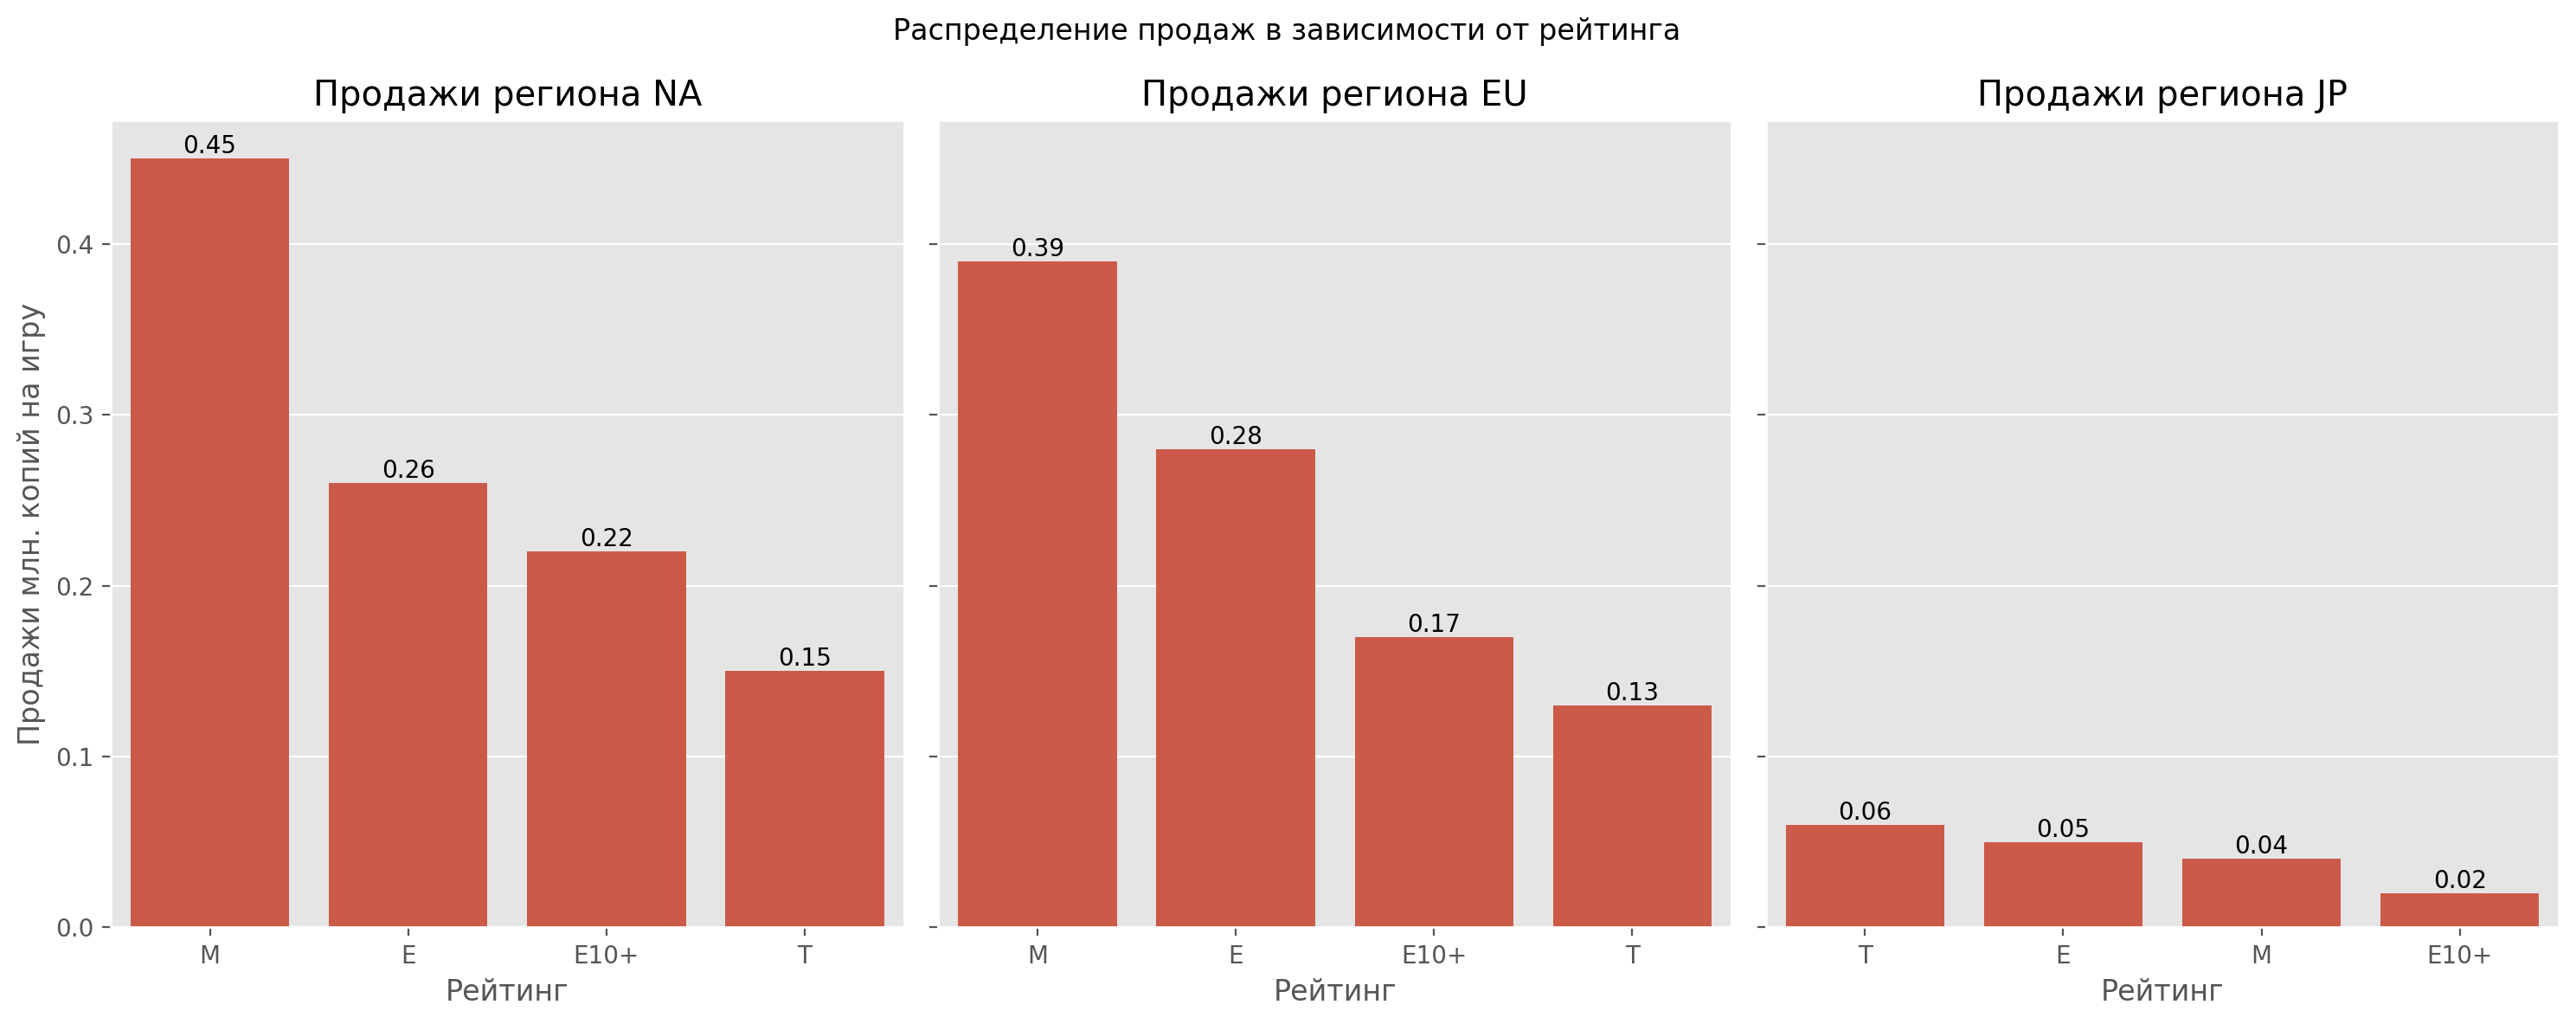

In [100]:
# Выведем регионы в отдельную переменную
regions_sales = ([('na_sales', 'Продажи региона NA'),
                  ('eu_sales', 'Продажи региона EU'),
                  ('jp_sales', 'Продажи региона JP')])
fig, axs = plt.subplots(1, 3, sharey=True)

# Запустим цикл с построением графиков
for ax, regions in zip(axs, regions_sales):
    sns.barplot(data=sales_per_rating.sort_values(by=regions[0], ascending=False),
                 x='rating',
                 y=regions[0],
                 ax=ax)

    ax.bar_label(ax.containers[0])
    ax.set_xlabel('Рейтинг')
    ax.set_ylabel('Продажи млн. копий на игру')
    ax.set_title(regions[1])


plt.suptitle('Распределение продаж в зависимости от рейтинга')
plt.tight_layout()
plt.show()

- В регионах NA и EU более популярным является жанр игр `M`- («Mature») — «Для взрослых». Копии игр этого жанра покупали чаще - 0.45 млн. и 0.39 млн. на 1 игру этого жанра. На втором месте - `E` - игры для всех. Меньше всего покупали игры жанра `T` («Teen») — «Подросткам» 0.15 млн. и 0.13 млн. на 1 игру этого жанра соответственно для регионов NA и EU.
- Регион JP отличается от двух других. Тут наблюдаются низкие продажи игр, у которых есть рейтинг. Больше всего купили игр жанра `T` - 0.06 млн. на 1 игру этого жанра, а всех меньше - Е10+ - 0.02 млн. на 1 игру этого жанра, что не сильно меньше. Объясняется эта зависимость также преобладанием карманных платформ, а также, вероятно, возрастным составом играющих. Вероятно, для этого рынка рейтинговая компания не дает рейтинги, а преобладают игры для внутренного рынка. Проверим это утверждение.

In [101]:
# сгруппируем только по региону JP
(df_since_2013.groupby('rating', as_index=False)[['jp_sales', 'name']]
 .agg({'jp_sales':'sum','name':'count'})
 .sort_values(by='jp_sales', ascending=False))

rating  jp_sales  name
3     RP     85.05   977
4      T     20.59   333
0      E     15.14   302
2      M     14.11   369
1   E10+      5.89   252

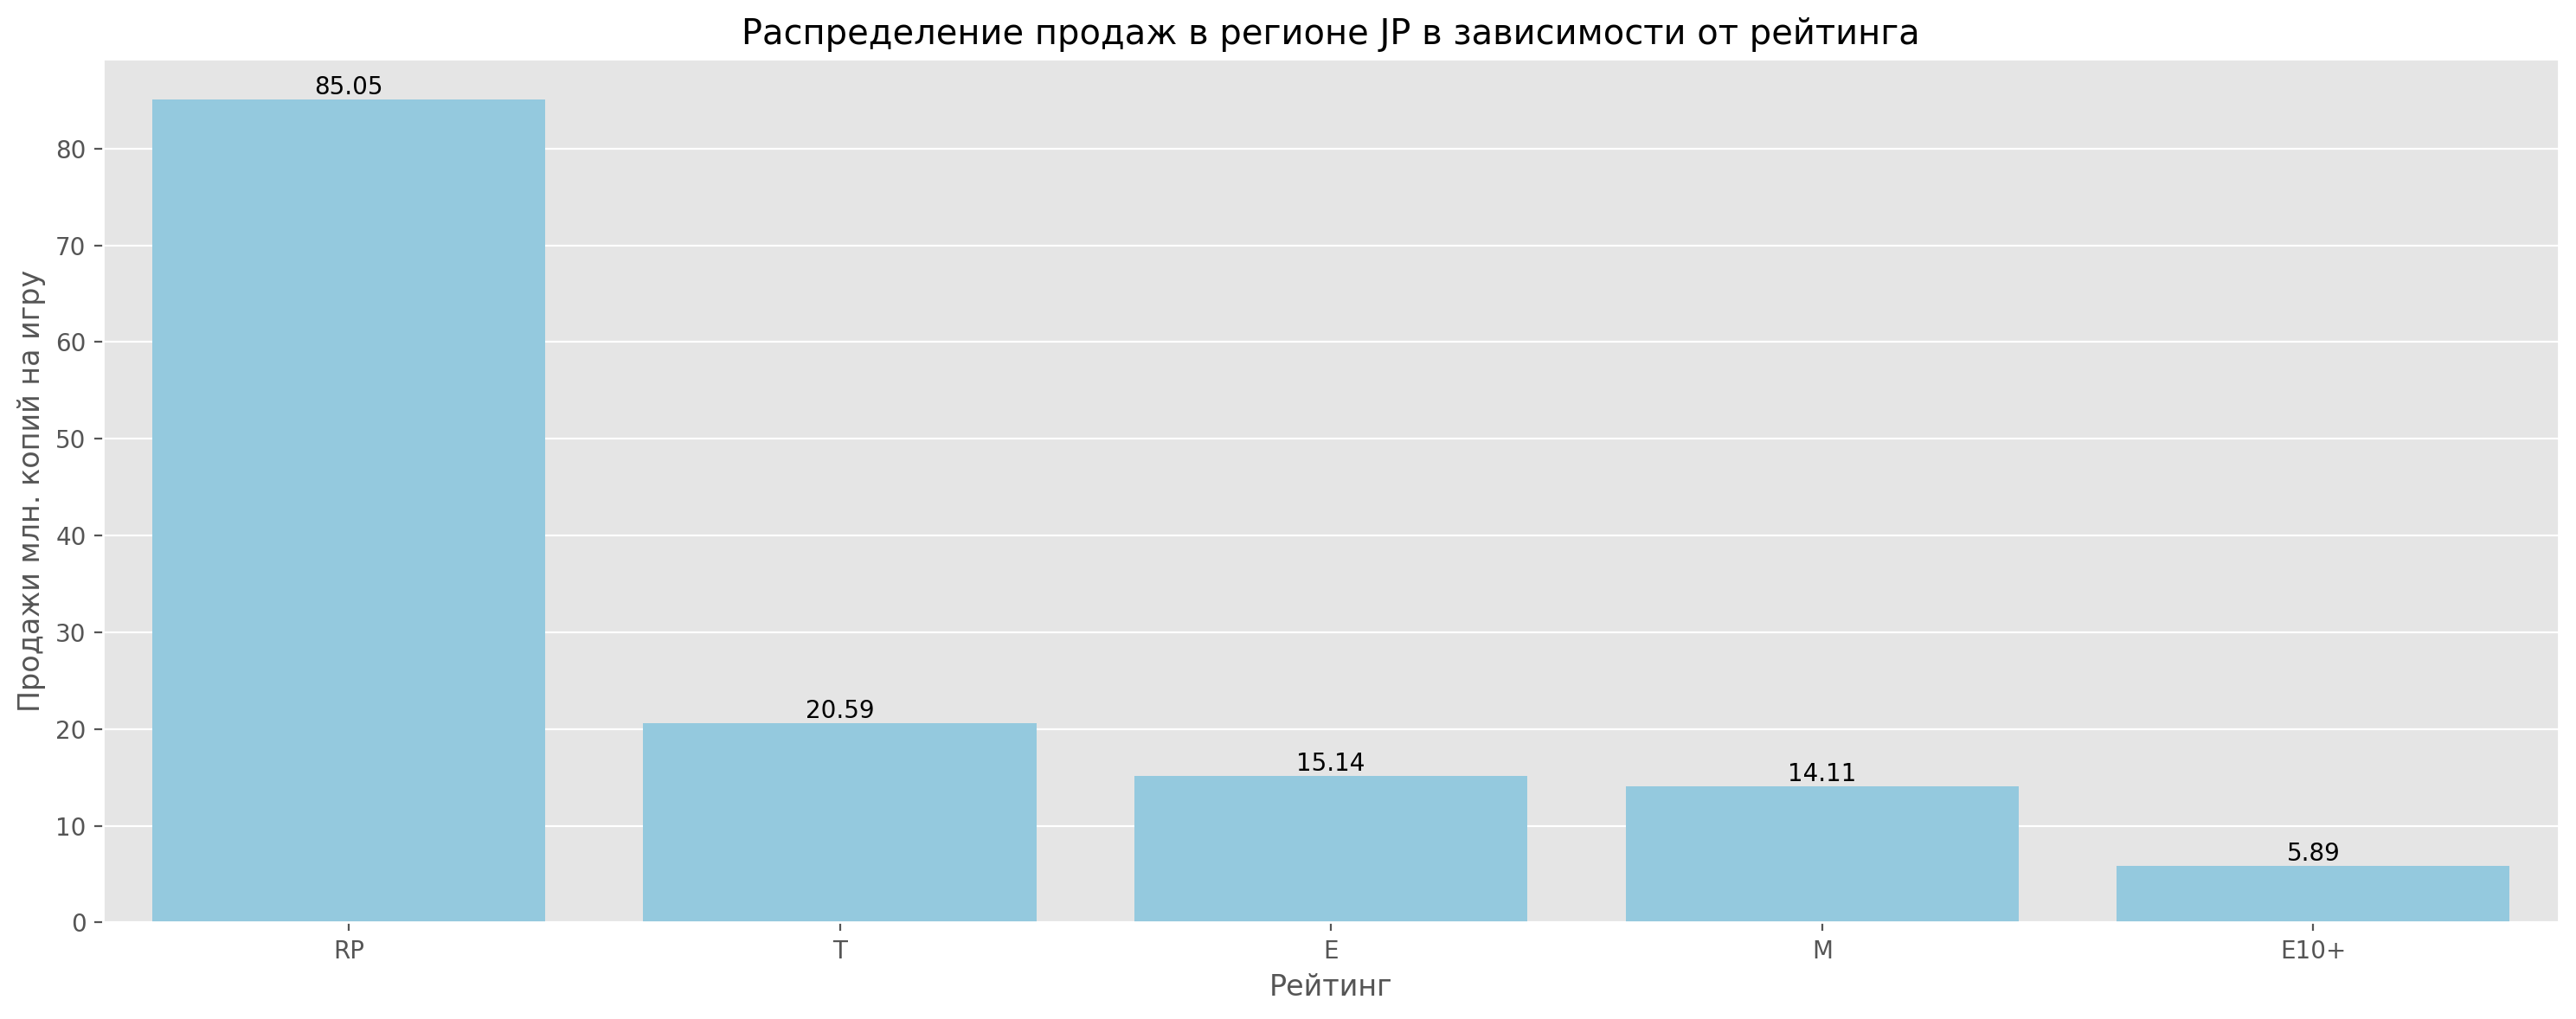

In [103]:
# Построим график по этому региону
ax = sns.barplot(data=(
    df_since_2013.groupby('rating', as_index=False)[['jp_sales', 'name']]
                 .agg({'jp_sales':'sum','name':'count'})).sort_values(by='jp_sales', ascending=False),
    x='rating',
    y='jp_sales',
    color='skyblue')

ax.bar_label(ax.containers[0])
ax.set_xlabel('Рейтинг')
ax.set_ylabel('Продажи млн. копий на игру')

plt.title('Распределение продаж в регионе JP в зависимости от рейтинга')
plt.tight_layout()
plt.show()

Наше предположение подтвердилось - игры без рейтинга в этом регионе занимают большую долю. Это говорит о том, что игры не проходили сертификацию в компании ESRB и, вероятно, являются продуктом для внутреннего рынка.

Краткий вывод:
1. Платформы:
- Наиболее популярная платформа в регионе NA - PS4 (108.74 млн. копий). На последнем месте по продажам - 3DS (38.20 млн. копий).
- В регионе EU наиболее популярны игры также на платформе PS4 (141.09 млн. копий). На втором месте - PS3 - это значит, что пользователи из этого региона предпочитают платформы от коипании Sony больше других платформ. На последнем месте платформа 3DS (продано 30.96 млню копий).
- В регионе JP предпочитают карманное устройство - 3DS - по 67.81 копий игр. На последнем месте WiiU - 10.88 млн. копий. Примечательно, что платформы X360 нет в топе 5. А все представленные платформы являются домашней продукцией.
2. Жанры:
- Топ 4 жанров регионов NA и EU одинаковые, что говорит об одинаковых предпочтениях в играх.
- Жанры в регионе JP довольно сильно отличаются. На первом месте здесь `Role-Playing` (51.04 млн. копий) и только на втором месте `Action`, хотя в двух других регионах этот жанр был Топ-1.
- Такое различие в предпочитаемых жанрах объясняется используемой платформой для игр. В Регионе JP предпочитают небольшие переносные платформы, на которых удобно играть в игры жанра `Role-Playing` и `Action`.
3. Рейтинг ESRB:
- Рейтинг влияет на продажи:
  - NA и EU более популярным является жанр игр M- («Mature») — «Для взрослых»
  - Регион JP предпочитает жанр T - "Teen". Возможное объяснение - не позволяет игровая платформа, разный возрастной состав, а также множество игр для внутреннего рынка.

## Гипотезы
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулируем Н0 и Н1:

H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Н1: Средние пользовательские рейтинги платформ Xbox One и PC разные.

In [107]:
# Выбераем данные оценок пользователей игр для платформы XOne
# сохраним в виде массива numpy
df_XOne = np.array(df.query('platform == "XOne" and year_of_release >= 2013 and user_score > 0')['user_score'])

# Выбераем данные оценок пользователей игр для платформы PC
# Год выпуска игры старше 2013, так как год выпуска XOne - 2013
# сохраним в виде списка
df_PC = np.array(df.query('platform == "PC" and year_of_release >= 2013 and user_score > 0')['user_score'])

Проверим нормальность распределения

Shapiro-Wilk для df_XOne: p-value=0.000
Shapiro-Wilk для df_PC: p-value=0.000
df_XOne: Отказываемся от нулевой гипотезы о нормальности.
df_PC: Отказываемся от нулевой гипотезы о нормальности.


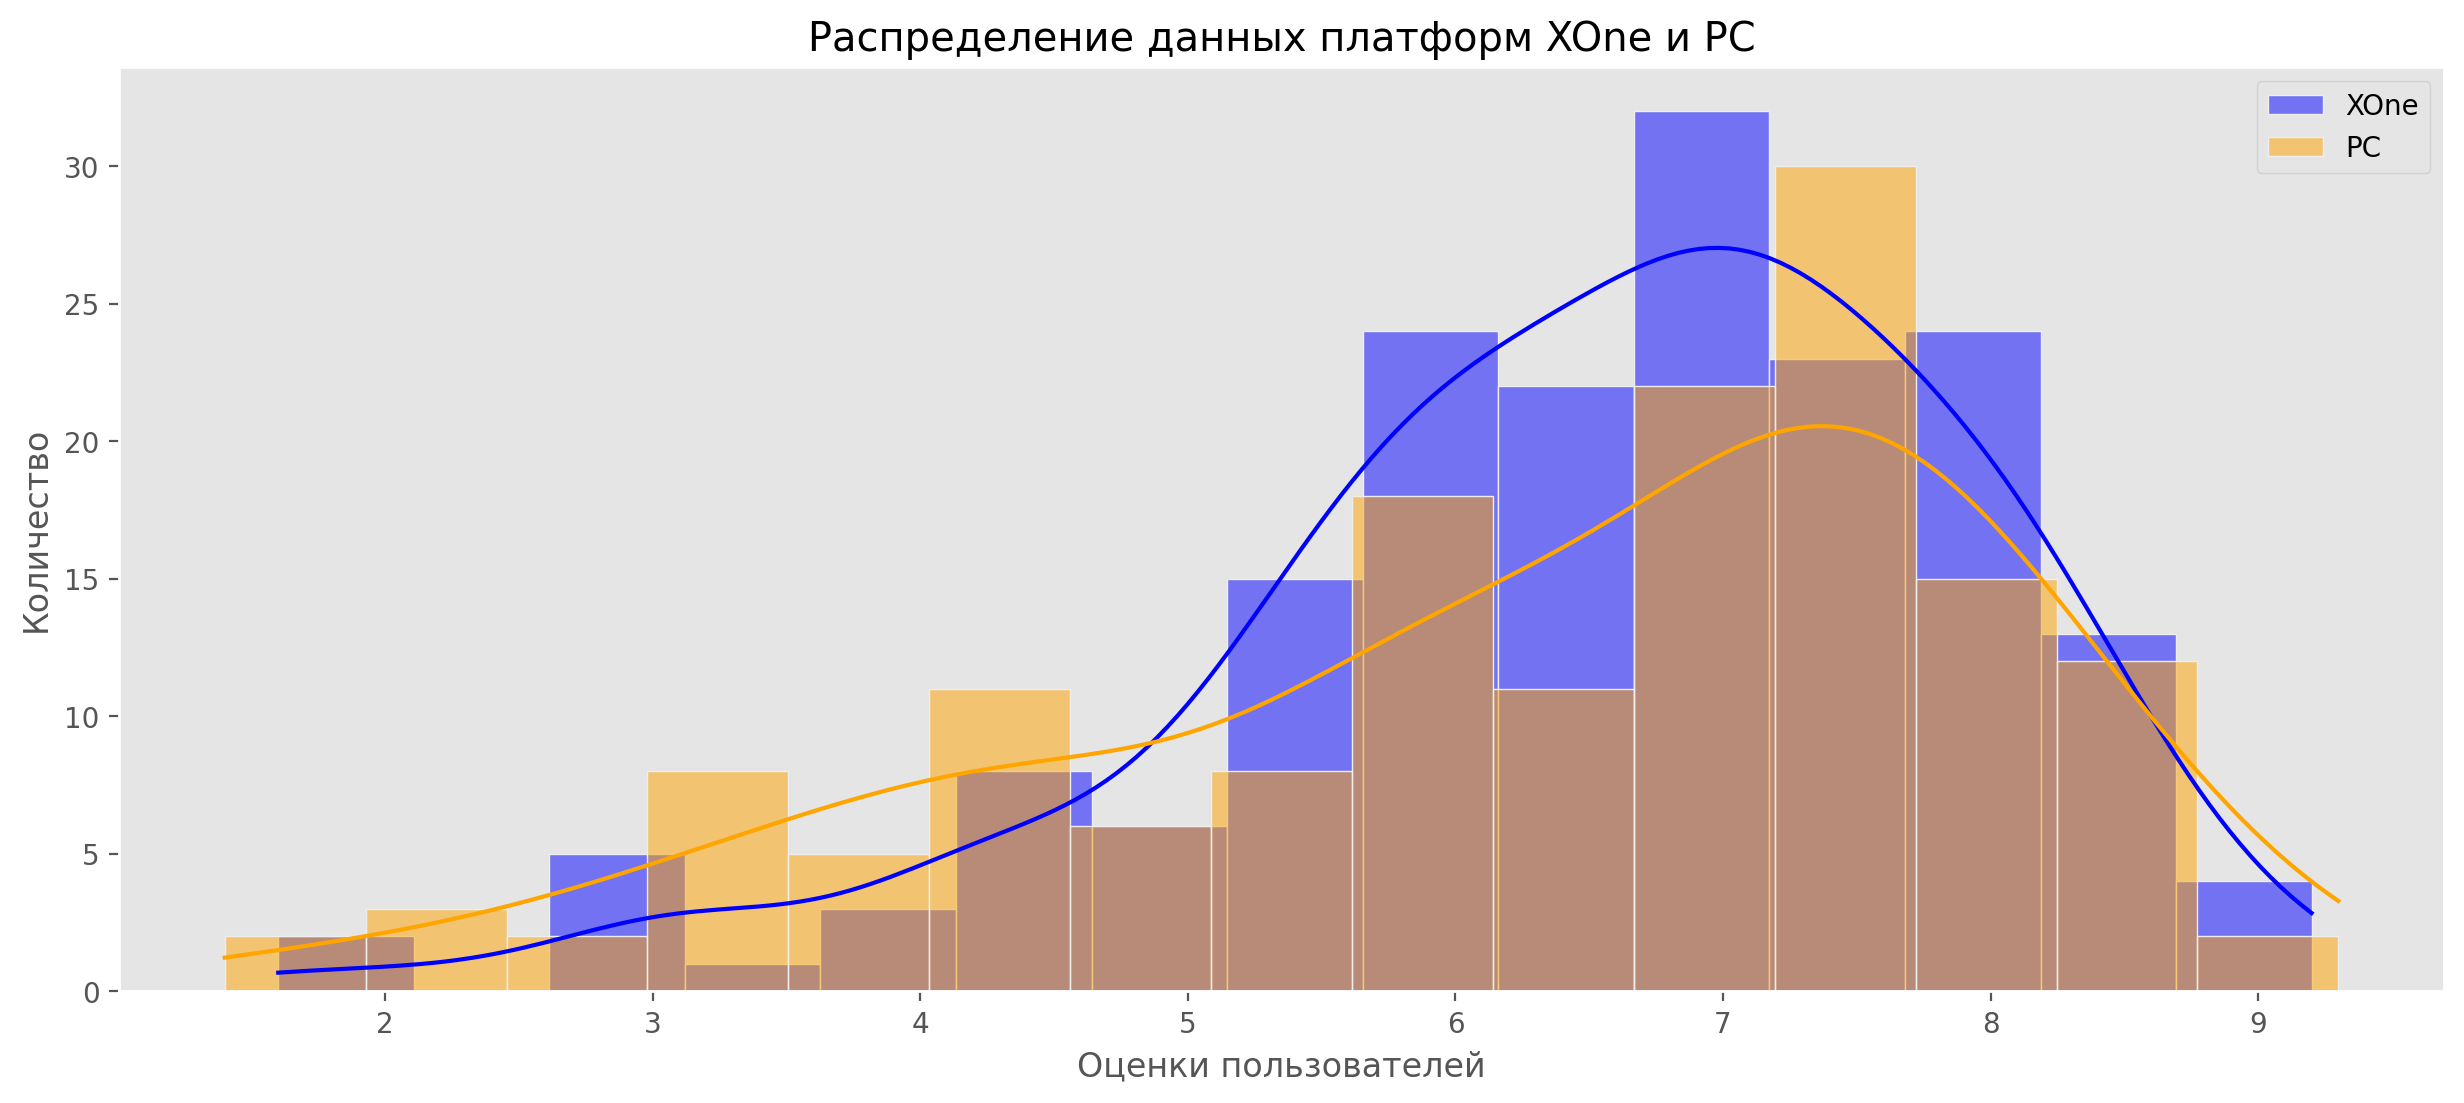

In [108]:
# Проверка нормальности распределения
shapiro_XOne = st.shapiro(df_XOne)
shapiro_PC = st.shapiro(df_PC)

print(f"Shapiro-Wilk для df_XOne: p-value={shapiro_XOne.pvalue:.3f}")
print(f"Shapiro-Wilk для df_PC: p-value={shapiro_PC.pvalue:.3f}")

# Если p-value < 0.05, то отказываемся от нулевой гипотезы о нормальности
alpha = 0.05
if shapiro_XOne.pvalue < alpha:
    print("df_XOne: Отказываемся от нулевой гипотезы о нормальности.")
else:
    print("df_XOne: Нормальное распределение.")

if shapiro_PC.pvalue < alpha:
    print("df_PC: Отказываемся от нулевой гипотезы о нормальности.")
else:
    print("df_PC: Нормальное распределение.")

# Визуализация распределения данных
sns.histplot(df_XOne, bins=15, color='blue', alpha=0.5, label='XOne', kde=True)
sns.histplot(df_PC, bins=15, color='orange', alpha=0.5, label='PC', kde=True)

plt.title('Распределение данных платформ XOne и PC')
plt.xlabel('Оценки пользователей')
plt.ylabel('Количество')
plt.legend()
plt.grid()
plt.show()

Как видно из результатов выше, наши данные не имеют нормального распределения, поэтому применять классический тест Стьюдента мы не можем. Воспользуемся тестом Манна-Уитни.

In [109]:
# Тест Манна-Уитни U
mann_whitney_test = st.mannwhitneyu(df_XOne, df_PC)
print(f"Тест Манна-Уитни U: p-value={mann_whitney_test.pvalue:.3f}")

# Интерпретация результатов
if mann_whitney_test.pvalue < alpha:
    print(f"Отвергаем нулевую гипотезу: медианы выборок различаются (p-value={mann_whitney_test.pvalue:.3f}).")
else:
    print(f"Не получилось отвергнуть нулевую гипотезу: медианы выборок не различаются (p-value={mann_whitney_test.pvalue:.3f}).")

Тест Манна-Уитни U: p-value=0.501
Не получилось отвергнуть нулевую гипотезу: медианы выборок не различаются (p-value=0.501).


От нулевой гипотезы не отказываемся, значит медианные значения пользовательских отзывов на игры платформ XOne и PC не различаются.

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Сформулируем гипотезы:

H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые.

Н1: Средние пользовательские рейтинги жанров Action и Sports разные.

In [110]:
# выделим выборку данных оценок пользователей игр для жанра Action
action = np.array(df.query('genre == "Action" and user_score > 0 and year_of_release >= 2013')['user_score'])

# выделим выборку данных оценок пользователей игр для жанра Sports
sports = np.array(df.query('genre == "Sports" and user_score > 0 and year_of_release >= 2013')['user_score'])

Проверим нормальность распределения

Shapiro-Wilk для Action: p-value=0.000
Shapiro-Wilk для Sports: p-value=0.032
shapiro_action: Отвергаем нулевую гипотезу о нормальности.
shapiro_sports: Отвергаем нулевую гипотезу о нормальности.


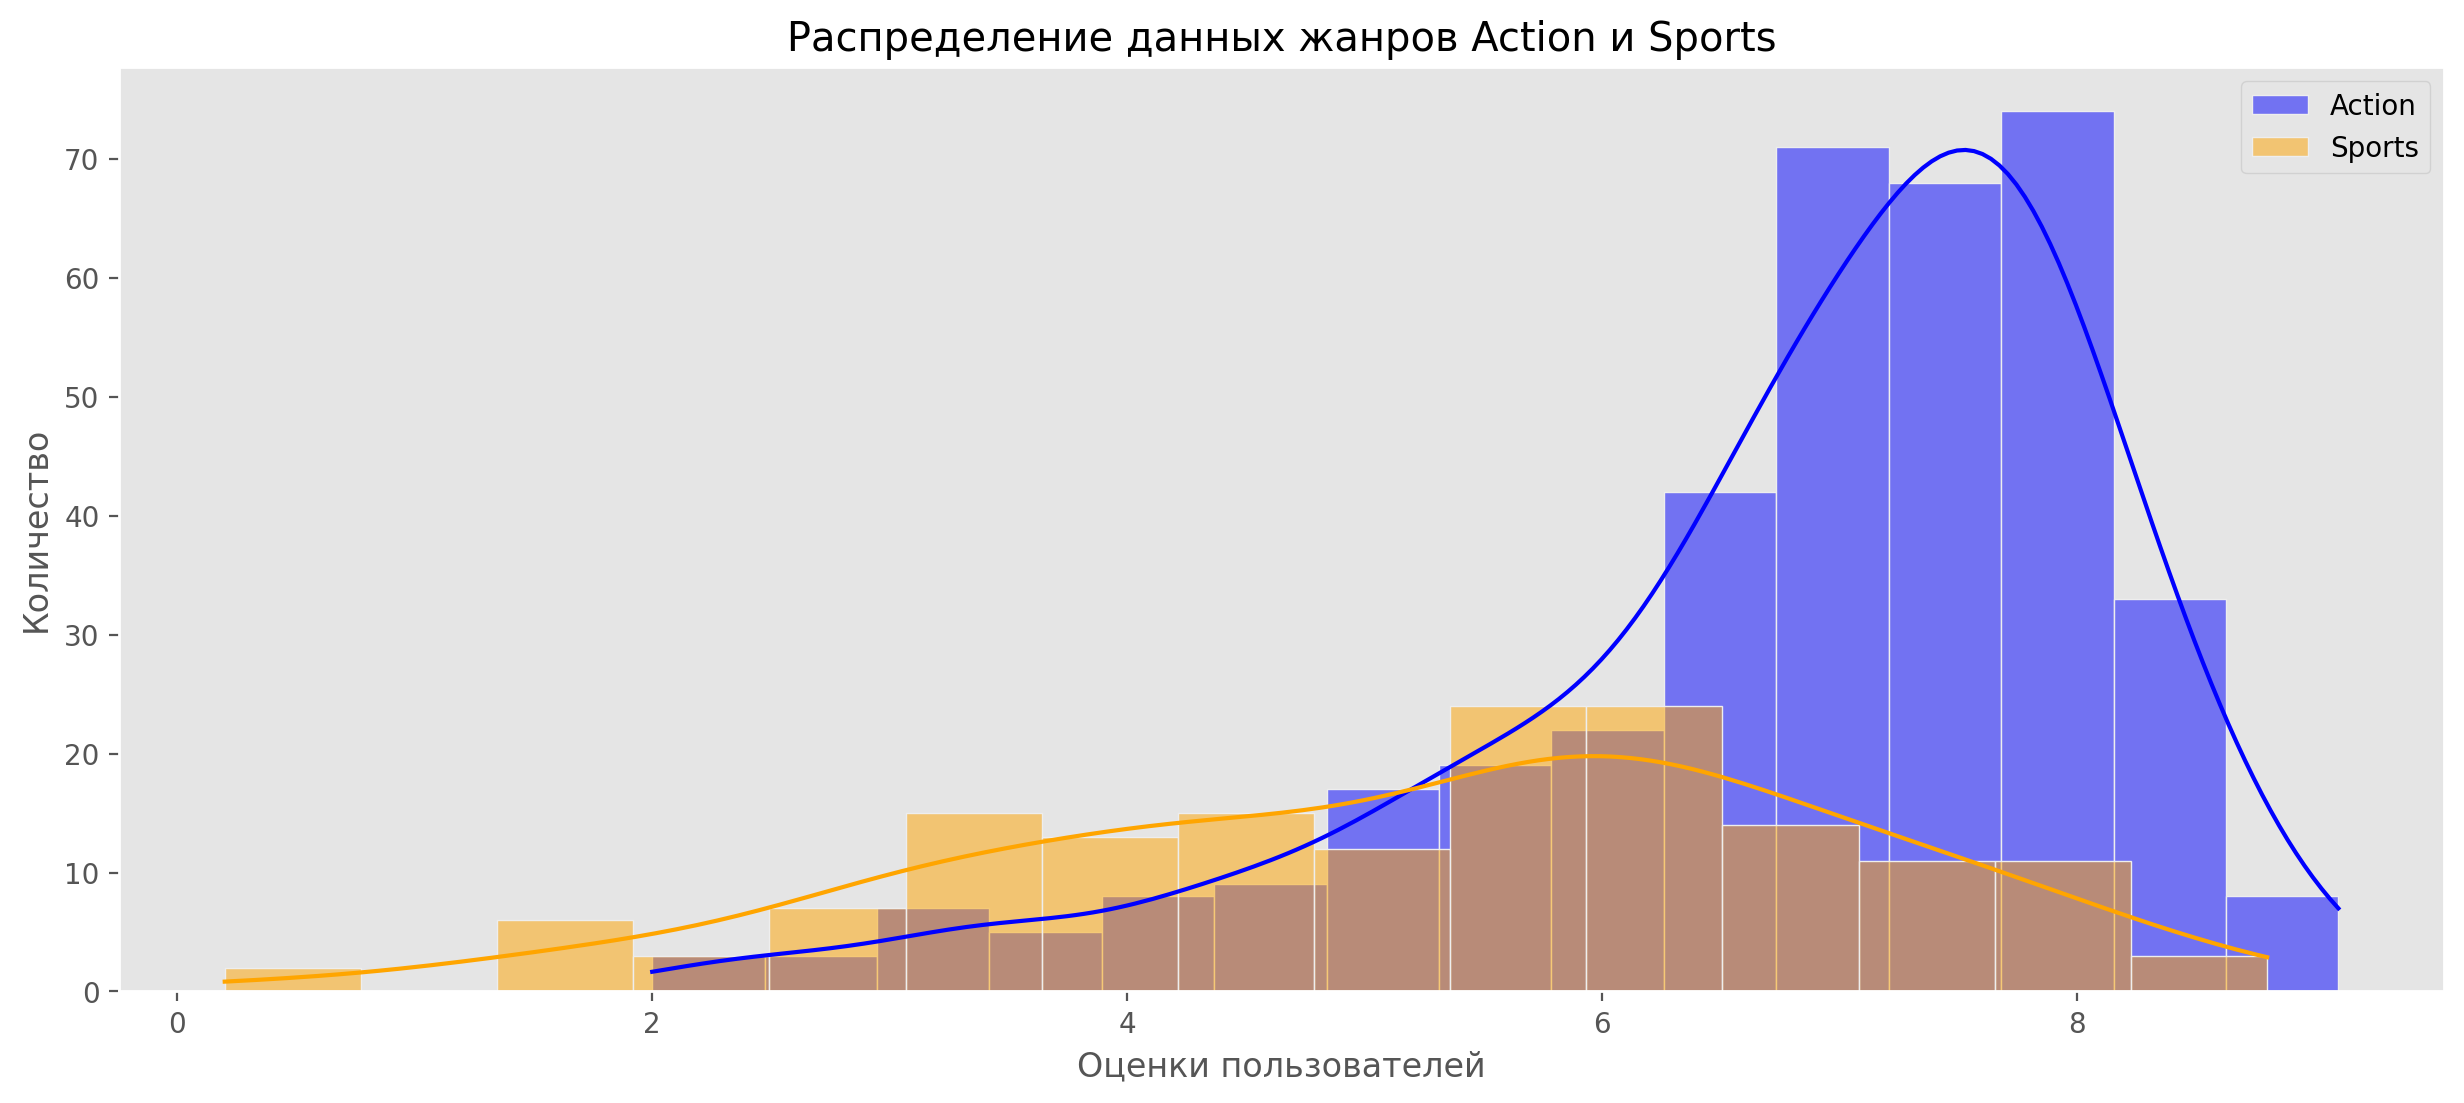

In [111]:
# Проверка нормальности распределения
shapiro_action = st.shapiro(action)
shapiro_sports = st.shapiro(sports)

print(f"Shapiro-Wilk для Action: p-value={shapiro_action.pvalue:.3f}")
print(f"Shapiro-Wilk для Sports: p-value={shapiro_sports.pvalue:.3f}")

# Если p-value < 0.05, то отказываемся от нулевой гипотезы о нормальности
alpha = 0.05
if shapiro_action.pvalue < alpha:
    print("shapiro_action: Отвергаем нулевую гипотезу о нормальности.")
else:
    print("shapiro_action: Нормальное распределение.")

if shapiro_sports.pvalue < alpha:
    print("shapiro_sports: Отвергаем нулевую гипотезу о нормальности.")
else:
    print("shapiro_sports: Нормальное распределение.")

# Визуализация распределения данных
sns.histplot(action, bins=15, color='blue', alpha=0.5, label='Action', kde=True)
sns.histplot(sports, bins=15, color='orange', alpha=0.5, label='Sports', kde=True)

plt.title('Распределение данных жанров Action и Sports')
plt.xlabel('Оценки пользователей')
plt.ylabel('Количество')
plt.legend()
plt.grid()
plt.show()

Две выборки также не имеют нормального распределения, поэтому применяем тест Манна-Уитни.


In [112]:
# Тест Манна-Уитни U
mann_whitney_test = st.mannwhitneyu(action, sports)
print(f"Тест Манна-Уитни U: p-value={mann_whitney_test.pvalue:.3f}")

# Интерпретация результатов
if mann_whitney_test.pvalue < alpha:
    print(f"Отвергаем нулевую гипотезу: медианы выборок различаются (p-value={mann_whitney_test.pvalue:.3f}).")
else:
    print(f"Не получилось отвергнуть нулевую гипотезу: медианы выборок не различаются (p-value={mann_whitney_test.pvalue:.3f}).")

Тест Манна-Уитни U: p-value=0.000
Отвергаем нулевую гипотезу: медианы выборок различаются (p-value=0.000).


Отвергаем нулевую гипотезу. Медианы выборок различаются.

Краткий вывод:
- Проверка гипотеза о равенстве средних оценок пользователей игр на платформах XOne и PC показала, что средние оценки статистически не различаются.
- Проверка гипотеза о том, что средние оценки пользователей игр жанров Action и Sports разные, показала, что средние оценки  статистически различаются.

## Общий вывод

1. Подготовка данных:
- Отформатировали колонки.
- Удалили не больше 5% пропусков.
- В колонках `critic_score` и `user_score `, пропуски заменили на 0.
- В колонке `rating ` на RP.
2. Исследовательский анализ данных:
- До 1991 года игр выпускалось немного. После 1991 наблюдается увеличение их количества.
- Продолжительность "жизни" платформ из топ 10 по продажам составляет примерно 9 лет. А среди худших по продажам -  5.1 лет и медиана 3.5 лет. Самая долгоживущая платформа - PC - 24 года (на момент 2016 года).
- В среднем игровые платформы последнего поколения (PS, Xbox и Wii) продают одинаковое количество игр.
- Есть слабая корреляция между оценками критиков и продажами игр 0.38-0.41. А связь между оценками пользователей и продажами игр почти отсутствует, за исключением платформы WiiU, где связь между оценками пользователей и продажами несколько выше (0.41), чем связь между оценками критиков и продажами (0.38).
- Наиболее продаваемым и имеющим наибольшее количество игр является жанр `Action` (игр жанра 766, было продано 321.9 млн. копий). Среди аутсайдеров - жанры  `Strategy` и `Puzzle`.
- Критики и пользователи сошлись во мнении, что игры жанра `Shooter` лучше остальных.
3. Портрет пользователя каждого региона:
- Платформы:
    - Наиболее популярная платформа в регионе NA - PS4 (108.74 млн. копий). На последнем месте по продажам - 3DS (38.20 млн. копий).
    - В регионе EU наиболее популярны игры также на платформе PS4 (141.09 млн. копий). На втором месте - PS3 - это значит, что пользователи из этого региона предпочитают платформы от коипании Sony больше других платформ. На последнем месте платформа 3DS (продано 30.96 млню копий).
    - В регионе JP предпочитают карманное устройство - 3DS - по 67.81 копий игр. На последнем месте WiiU - 10.88 млн. копий. Примечательно, что платформы X360 нет в топе 5. А все представленные платформы являются домашней продукцией.
- Жанры:
    - Топ 4 жанров регионов NA и EU одинаковые, что говорит об одинаковых предпочтениях в играх.
    - Жанры в регионе JP довольно сильно отличаются. На первом месте здесь `Role-Playing` (51.04 млн. копий) и только на втором месте `Action`, хотя в двух других регионах этот жанр был Топ-1.
    - Такое различие в предпочитаемых жанрах объясняется используемой платформой для игр. В Регионе JP предпочитают небольшие переносные платформы, на которых удобно играть в игры жанра `Role-Playing` и `Action`.

В итоге, игроки регионов NA и EU очень близкие по игровым предпочтениям друг к другу. Играют в одни и те же игры, но немного отличаются предпочтению в платформах - среди игроков из NA на втором месте по распространенности домашняя платформа от Microsoft. В регионе EU предпочитают платформы от Sony. Игроки региона JP сильно отличаются от других регионов. Тут предпочтают переносные небольшие устройства только местного производства и играют в основном в игры для внутреннего рынка.

4. Проверка гипотез о равенстве средних:
- Проверка гипотеза о равенстве средних оценок пользователей игр на платформах XOne и PC показала, что средние оценки статистически не различаются.
- Проверка гипотеза о том, что средние оценки пользователей игр жанров Action и Sports разные, показала, что средние оценки статистически различаются.
